In [ ]:
rm(list = ls())
gc()

setwd("/mnt/data00/minghui/project_NMF/")
library(Seurat)
library(dplyr)
library(cowplot)
library(harmony)
library(readr) 
library(tidyr)
library(gplots)
library(reshape2)
library(paletteer)
library(AUCell)
library(pheatmap)
suppressPackageStartupMessages(library(NMF))
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(scibet))
suppressMessages(library(viridis))
suppressMessages(library(ggsci))
 
d_palettes<- palettes_d_names
mycol<-paletteer_d( "ggsci::default_igv",n=51)

source('../Fuctions/Markers_kno.R')
source('../Fuctions/seurat_functions.R')

library(ComplexHeatmap)
library(circlize)

library(scater)


library(htmlwidgets)

library(GSVA)



In [19]:
library(ggrepel)

# Function to generate UMAP plot for each module
plot_umap_for_module <- function(module_name) {
  # Calculate AUCell for the module
  AUCell_auc <- as.numeric(getAUC(cells_AUC)[module_name, ])
  # Add to metadata
  data$AUCell <- AUCell_auc
  
  # Extract UMAP coordinates data
  umap <- data.frame(data@meta.data, data@reductions$umap@cell.embeddings)
  
  # Calculate median coordinates for each cell type
  cell_type_med <- umap %>%
    dplyr::group_by(cell_type) %>%
    summarise(
      UMAP_1 = median(UMAP_1),
      UMAP_2 = median(UMAP_2)
    )
  
  # Generate plot
  p <- ggplot(umap, aes(UMAP_1, UMAP_2)) +
    geom_point(aes(colour = AUCell)) +
    scale_colour_gradientn(colours = custom_palette(100)) + # Apply custom color palette    theme_bw() +
    ggtitle(paste("UMAP Plot for Module:", module_name))
  
}

In [12]:
cluster_cols <- c(
  "#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72",
  "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", "#E78AC3",
  "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D",
  "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999",
  "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000",
  "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")


my36colors <- c('#53A85F', '#F1BB72', '#D6E7A3', '#57C3F3', '#476D87', '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658', '#9FA3A8', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398', '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B', '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963', '#968175', '#E5D2DD', '#E0D4CA', '#F3B1A0' )

col.list <- list(Tissuetype = c('BE-IM' = my36colors[1], 
                              'BSCJ' = my36colors[2], 
                              'CAG' = my36colors[3],
                              'CIM' = my36colors[4],
                              'Colon' = my36colors[5],
                              'E-GM' = my36colors[6],
                              'GIM' = my36colors[7],
                              'Ileum' = my36colors[8],
                              'NAG' = my36colors[9],
                              'ND' = my36colors[10],
                              'NGB' = my36colors[11],
                              'NGC' = my36colors[12],
                              'NSCJ' = my36colors[13],
                              'Rectum' = my36colors[14]
))

###  Normal Tissues:

In [3]:
# Read the saved RDS files 
setwd("/mnt/data00/minghui/project_NMF/02_NMFAllTissue/")

modules_L <- readRDS(file = "./03_modules_L.rds")
res_optima_L <- readRDS(file = "./03_res_optima_L.rds") 
coefs_L <- readRDS(file = "./03_coefs_L.rds") 
scores_L <- readRDS(file = "./03_scores_L.rds")

In [5]:
scores_L[[2]][1:4,]

m_GKN1        m_MALAT1      m_SLC7A11     m_MT1G        m_GEM        
GKN1   2.486256e-02 6.072285e-202 4.940656e-324 1.534514e-121 4.940656e-324
PGC    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
LYZ    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
REG1A 9.488699e-103  2.448150e-96 4.940656e-324 4.940656e-324 4.940656e-324
      m_LYZ       m_H4C3        m_FOS         m_TIMP1      
GKN1  0.000000000  0.000000e+00 4.940656e-324 4.940656e-324
PGC   0.016622476 4.940656e-324  0.000000e+00  0.000000e+00
LYZ   0.017441929 4.940656e-324 4.940656e-324  0.000000e+00
REG1A 0.009230717 4.940656e-324 1.432790e-322 4.940656e-324

In [37]:
SC_Columnar_normal <-readRDS('./03_nsNMF_ALL_TIssue_Normal/SC_Columnar_normal.rds')

table( SC_Columnar_normal$Tissue_in_paper)


 BE-IM   BSCJ    CAG    CIM  Colon   E-GM    GIM  Ileum    NAG     ND    NGB 
     0      0      0    946   4220      0      0   6737      0   3199   2636 
   NGC   NSCJ Rectum 
  7894   2603   3150 

### Healthy_stomach

In [39]:
# Healthy_intestine <- c('Colon','Ileum','ND','Rectum')

# Healthy_stomach <-c('NGB','NGC','NSCJ')

Healthy_stomach <- subset(SC_Columnar_normal , Tissue_in_paper %in% c('NGB','NGC','NSCJ'))

Healthy_intestine <- subset(SC_Columnar_normal , Tissue_in_paper %in% c('Colon','Ileum','ND','Rectum'))

In [73]:
Healthy_stomach_res_optima_L <- res_optima_L[table(Healthy_stomach$sample_name) %>%names()]

#subset

Healthy_stomach_res_optima_L <- Filter(Negate(is.null), Healthy_stomach_res_optima_L)



Healthy_stomach_modules.list = lapply(Healthy_stomach_res_optima_L, NMFToModules)

In [85]:
all = unlist(Healthy_stomach_modules.list, recursive = FALSE, use.names = FALSE)

names(all) = unlist(sapply(Healthy_stomach_modules.list, names))
ta = table(unlist(all))
genes.use = names(ta)[ta > 1]

# names((Healthy_stomach_modules.list)

[1] 198
[1] 198
[1] 198
[1] 198
[1] 198


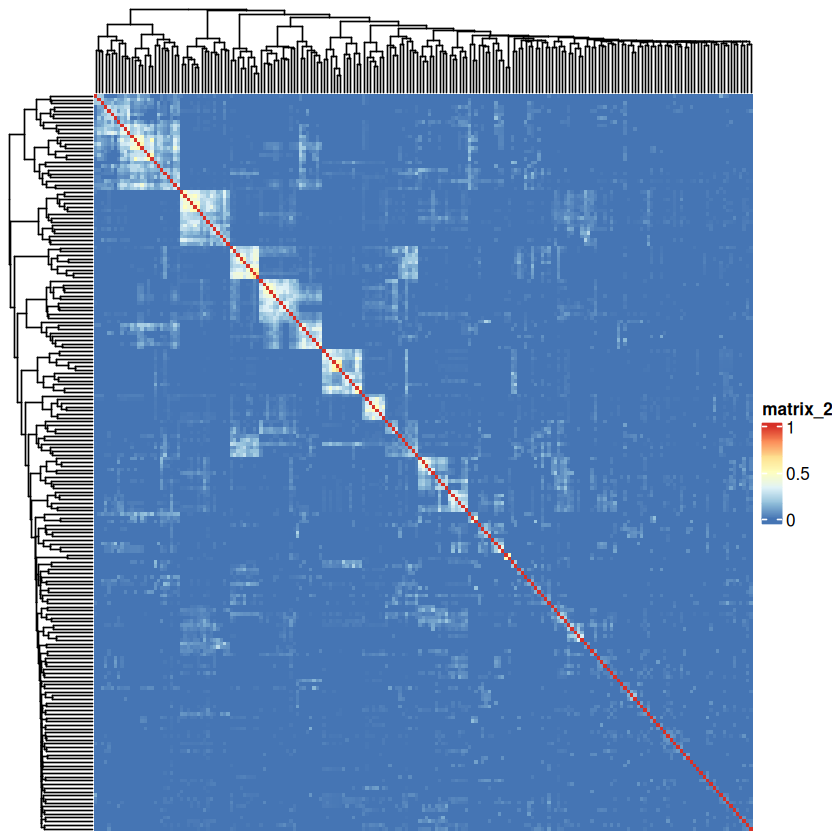

In [86]:
for (i in 1:5){
  all = unlist(Healthy_stomach_modules.list, recursive = FALSE, use.names = TRUE)
  all = lapply(all, intersect, genes.use)
  sim = sapply(all, function(x){
    sapply(all, function(y){
      length(intersect(x,y))/length(union(x,y))
    })
  })
  keep = rownames(sim)[apply(sim, 1, function(x){
    # sum(x > 0.05) >= 5
    sum(x > 0.05) >= 2
  })]
  all = all[keep]
  modules.list = lapply(names(Healthy_stomach_modules.list), function(x){
    li = modules.list[[x]]
    li[names(li)[paste(x,names(li),sep='.') %in% keep]]
  })
  names(Healthy_stomach_modules.list) =  names(Healthy_stomach_res_optima_L)
  ta = table(unlist(all))
  genes.use = names(ta)[ta > 1] 
  print(length(all))
}
# Filter the modules in the similarity matrix and keep those modules whose similarity coefficient with at least 5 other modules is greater than 0.05
pheatmap(sim,scale =T ,show_rownames= F, show_colnames = F)

In [87]:
sim[1:10,1:10]

P5846_normal.m_MUC6 P5846_normal.m_LIPF
P5846_normal.m_MUC6        1.00000000          0.00000000         
P5846_normal.m_LIPF        0.00000000          1.00000000         
P5846_normal.m_LYZ         0.00000000          0.00000000         
P5846_normal.m_ATP5F1C     0.00000000          0.00000000         
P5866_normal_rep2.m_KLK11  0.00000000          0.03225806         
P5866_normal_rep2.m_FABP5  0.00000000          0.00000000         
P5866_normal_rep2.m_PICALM 0.00000000          0.00000000         
P5866_normal_rep2.m_GKN1   0.00000000          0.01136364         
P5866_normal_rep2.m_BPIFB1 0.00000000          0.00000000         
P5866_normal_rep2.m_RND1   0.02197802          0.00000000         
                           P5846_normal.m_LYZ P5846_normal.m_ATP5F1C
P5846_normal.m_MUC6        0.00000000         0.00000000            
P5846_normal.m_LIPF        0.00000000         0.00000000            
P5846_normal.m_LYZ         1.00000000         0.00000000            
P5846_normal.m_ATP5F1C     0.00000000         1.00000000            
P5866_normal_rep2.m_KLK11  0.00000000         0.00000000            
P5866_normal_rep2.m_FABP5  0.02469136         0.00000000            
P5866_normal_rep2.m_PICALM 0.00000000         0.00000000            
P5866_normal_rep2.m_GKN1   0.10309278         0.01324503            
P5866_normal_rep2.m_BPIFB1 0.01204819         0.00000000            
P5866_normal_rep2.m_RND1   0.00000000         0.00000000            
                           P5866_normal_rep2.m_KLK11 P5866_normal_rep2.m_FABP5
P5846_normal.m_MUC6        0.00000000                0.00000000               
P5846_normal.m_LIPF        0.03225806                0.00000000               
P5846_normal.m_LYZ         0.00000000                0.02469136               
P5846_normal.m_ATP5F1C     0.00000000                0.00000000               
P5866_normal_rep2.m_KLK11  1.00000000                0.00000000               
P5866_normal_rep2.m_FABP5  0.00000000                1.00000000               
P5866_normal_rep2.m_PICALM 0.00000000                0.00000000               
P5866_normal_rep2.m_GKN1   0.00000000                0.00000000               
P5866_normal_rep2.m_BPIFB1 0.00000000                0.00000000               
P5866_normal_rep2.m_RND1   0.00000000                0.00000000               
                           P5866_normal_rep2.m_PICALM P5866_normal_rep2.m_GKN1
P5846_normal.m_MUC6        0                          0.00000000              
P5846_normal.m_LIPF        0                          0.01136364              
P5846_normal.m_LYZ         0                          0.10309278              
P5846_normal.m_ATP5F1C     0                          0.01324503              
P5866_normal_rep2.m_KLK11  0                          0.00000000              
P5866_normal_rep2.m_FABP5  0                          0.00000000              
P5866_normal_rep2.m_PICALM 1                          0.00000000              
P5866_normal_rep2.m_GKN1   0                          1.00000000              
P5866_normal_rep2.m_BPIFB1 0                          0.00000000              
P5866_normal_rep2.m_RND1   0                          0.00000000              
                           P5866_normal_rep2.m_BPIFB1 P5866_normal_rep2.m_RND1
P5846_normal.m_MUC6        0.00000000                 0.02197802              
P5846_normal.m_LIPF        0.00000000                 0.00000000              
P5846_normal.m_LYZ         0.01204819                 0.00000000              
P5846_normal.m_ATP5F1C     0.00000000                 0.00000000              
P5866_normal_rep2.m_KLK11  0.00000000                 0.00000000              
P5866_normal_rep2.m_FABP5  0.00000000                 0.00000000              
P5866_normal_rep2.m_PICALM 0.00000000                 0.00000000              
P5866_normal_rep2.m_GKN1   0.00000000                 0.00000000              
P5866_normal_rep2.m_BPIFB1 1.00000000                 0.00000000              
P58

In [88]:
sub = matrix(0, nrow = length(genes.use), ncol = length(genes.use))
  rownames(sub) = genes.use
  colnames(sub) = genes.use
  for (s in names(Healthy_stomach_modules.list)){
    for (mod in Healthy_stomach_modules.list[[s]]){
      mod = intersect(mod, genes.use)
      for (x in mod){
        for (y in mod){
          sub[x,y] = sub[x,y] + 1
        }
      }
    }
  }
  diag(sub) = 0
adj_keep = sub


v_min = 2 # from 3 to 2 

s_min = 1 # from 2 to 1 

adj = adj_keep 

adj[] = (adj >= v_min) 

for (i in 1:5){ 
    keep = names(which(rowSums(adj) >= s_min))
    adj = adj[keep,keep] 
    print(dim(adj))
}

[1] 981 981
[1] 981 981
[1] 981 981
[1] 981 981
[1] 981 981


In [92]:
g = graph_from_adjacency_matrix(adj, diag = FALSE, mode = 'undirected', weighted = TRUE)
Healthy_stomach_modules = communities(cluster_infomap(g, nb.trials = 200))
names(Healthy_stomach_modules) = paste0('m_', sapply(Healthy_stomach_modules, '[', 1))


my_lengths <- sapply(Healthy_stomach_modules, length)

Healthy_stomach_modules <- subset(Healthy_stomach_modules, my_lengths > 2)

 a <-lapply(Healthy_stomach_modules, list)
Healthy_stomach_modules <-lapply(a, unlist)

### Healthy stomach modules

In [90]:
Healthy_stomach_modules

$m_ABCC3
 [1] "ABCC3"       "ACADVL"      "ANKRD11"     "ANKRD36C"    "ANXA1"      
 [6] "ARGLU1"      "CAPN8"       "CDC42BPA"    "CRACR2B"     "CSKMT"      
[11] "CSRNP2"      "CYP3A5"      "DDX17"       "EIF4A1"      "ELF3"       
[16] "ELL2"        "FAM133B"     "FLNB"        "FMN1"        "FUS"        
[21] "H2BC8"       "HES1"        "HEXIM1"      "HSPA5"       "INTS6"      
[26] "KANSL1"      "KCNQ1OT1"    "LIPH"        "MALAT1"      "MEPCE"      
[31] "NEAT1"       "PARP14"      "PLCG2"       "RAB11FIP1"   "RICTOR"     
[36] "RND3"        "SAT1"        "SCNN1A"      "SLC38A2"     "SOX4"       
[41] "SPIRE2"      "SPRR3"       "SQSTM1"      "STX5.DT"     "SYTL2"      
[46] "TAPBP"       "TCIM"        "THUMPD3.AS1" "TLE4"        "TTC14"      
[51] "VMP1"        "ZFP36L2"    

$m_ABCC5
[1] "ABCC5" "ABHD2" "INF2" 

$m_ABHD5
 [1] "ABHD5"    "ADM"      "ALDH3A1"  "ANKRD37"  "ANXA4"    "AREG"    
 [7] "ARL14"    "ARL5B"    "BIRC3"    "CBX4"     "CCN1"     "CCN2"    
[13] "CEBPD"    "CHP1"     "CITED2"   "CXCL2"    "CXCL8"    "DNAJA1"  
[19] "DNAJA4"   "DNAJB1"   "EFNA1"    "FOSB"     "GADD45B"  "GPRC5A"  
[25] "HBEGF"    "HSP90AA1" "HSPA1A"   "HSPA1B"   "HSPA6"    "HSPB1"   
[31] "HSPH1"    "ID2"      "ID3"      "IER3"     "IRF1"     "ITPKC"   
[37] "JDP2"     "JUND"     "KLF2"     "KLF6"     "LARP4"    "LDLR"    
[43] "LTF"      "MAFF"     "MTHFD2"   "MYLIP"    "NAMPT"    "NCOA7"   
[49] "NFKBIA"   "NFKBIZ"   "ODC1"     "PHLDA2"   "PLK2"     "PMAIP1"  
[55] "PPP1R15A" "PTP4A1"   "RAP2B"    "RHOB"     "RND1"     "SDC4"    
[61] "SELENOW"  "SERTAD1"  "SOCS3"    "SPDEF"    "TACSTD2"  "TENT5A"  
[67] "TGIF1"    "TNFAIP3"  "TOB1"     "UBB"      "UBC"      "WEE1"    
[73] "YPEL2"    "ZBTB43"   "ZC3HAV1"  "ZFAND2A"  "ZFP36"    "ZFP36L1" 

$m_ACADM
  [1] "ACADM"      "ACAT1"      "ACO2"       "ADA"        "AKR7A3"    
  [6] "ALDH1A1"    "ATP1B1"     "ATP4A"      "ATP4B"      "ATP5F1A"   
 [11] "ATP5F1B"    "ATP5F1C"    "ATP5MC1"    "ATP5MC3"    "ATP5ME"    
 [16] "ATP5MG"     "ATP5MJ"     "ATP5MK"     "ATP5PB"     "ATP5PD"    
 [21] "ATP5PF"     "ATP5PO"     "BNIP3"      "BOLA3"      "BSG"       
 [26] "CALM1"      "CBLIF"      "CHCHD10"    "CKB"        "CLIC6"     
 [31] "COA3"       "COMMD6"     "COX17"      "COX5A"      "COX5B"     
 [36] "COX6B1"     "COX7A2"     "COX7B"      "COX7C"      "CYC1"      
 [41] "CYCS"       "DDT"        "DLD"        "ECHS1"      "ECI2"      
 [46] "ESRRG"      "EZR"        "FABP3"      "FTH1"       "FXYD4"     
 [51] "G0S2"       "GHITM"      "GLOD4"      "GLUL"       "GOT1"      
 [56] "GPR155"     "GPX4"       "GSTA1"      "HADHB"      "HIBADH"    
 [61] "IDH2"       "INSIG1"     "ISCU"       "KCNE2"      "KIAA1191"  
 [66] "LDHB"       "MDH1"       "MDH2"       "MPC1"       "MPC2"      
 [71] "MRPL41"     "NDUFA1"     "NDUFA10"    "NDUFA4"     "NDUFA5"    
 [76] "NDUFA6"     "NDUFAB1"    "NDUFB7"     "NDUFC1"     "NDUFS2"    
 [81] "NDUFS3"     "NDUFS7"     "NDUFS8"     "NDUFV1"     "NFE2L2"    
 [86] "NHERF1"     "NR0B2"      "PBLD"       "PDHA1"      "PHLDA1"    
 [91] "PLEKHB2"    "PRDX2"      "PRDX5"      "PXMP2"      "RAB4A"     
 [96] "REXO2"      "SDHB"       "SDHC"       "SKAP2"      "SLC25A3"   
[101] "SLC25A4"    "SLC25A5"    "SOD1"       "SPINT1.AS1" "STX12"     
[106] "SUCLG1"     "SUCLG2"     "TBCA"       "TM7SF2"     "TPD52L1"   
[111] "TPI1"       "UQCR11"     "UQCRB"      "UQCRC1"     "UQCRC2"    
[116] "UQCRFS1"    "UQCRH"      "UQCRQ"      "VDAC1"      "VRK1"      

$m_ACOT13
[1] "ACOT13"  "DUSP4"   "H1.2"    "TAX1BP1"

$m_ACOT7
  [1] "ACOT7"     "ACSL1"     "APLP1"     "APOA1"     "ARFGEF3"   "ATF3"     
  [7] "B2M"       "BCAM"      "BEX1"      "BEX2"      "BEX3"      "BHMT"     
 [13] "BTG2"      "C12orf75"  "C2CD4B"    "CACNA1A"   "CALD1"     "CAMK2N1"  
 [19] "CBX6"      "CD24"      "CEP126"    "CEP164"    "CFC1"      "CHGA"     
 [25] "CHGB"      "CIRBP"     "CITED4"    "CLDN4"     "CLU"       "CPE"      
 [31] "CRYBA2"    "DDX5"      "DEPP1"     "DPP7"      "DUSP1"     "E

### Healthy_intestine

In [107]:
Healthy_intestine_res_optima_L <- res_optima_L[table(Healthy_intestine$sample_name) %>%names()]

#subset

Healthy_intestine_res_optima_L <- Filter(Negate(is.null), Healthy_intestine_res_optima_L)



Healthy_intestine_modules.list = lapply(Healthy_intestine_res_optima_L, NMFToModules)

In [109]:
all = unlist(Healthy_intestine_modules.list, recursive = FALSE, use.names = FALSE)

names(all) = unlist(sapply(Healthy_intestine_modules.list, names))
ta = table(unlist(all))
genes.use = names(ta)[ta > 1]

# names((Healthy_stomach_modules.list)

[1] 115
[1] 115
[1] 115
[1] 115
[1] 115


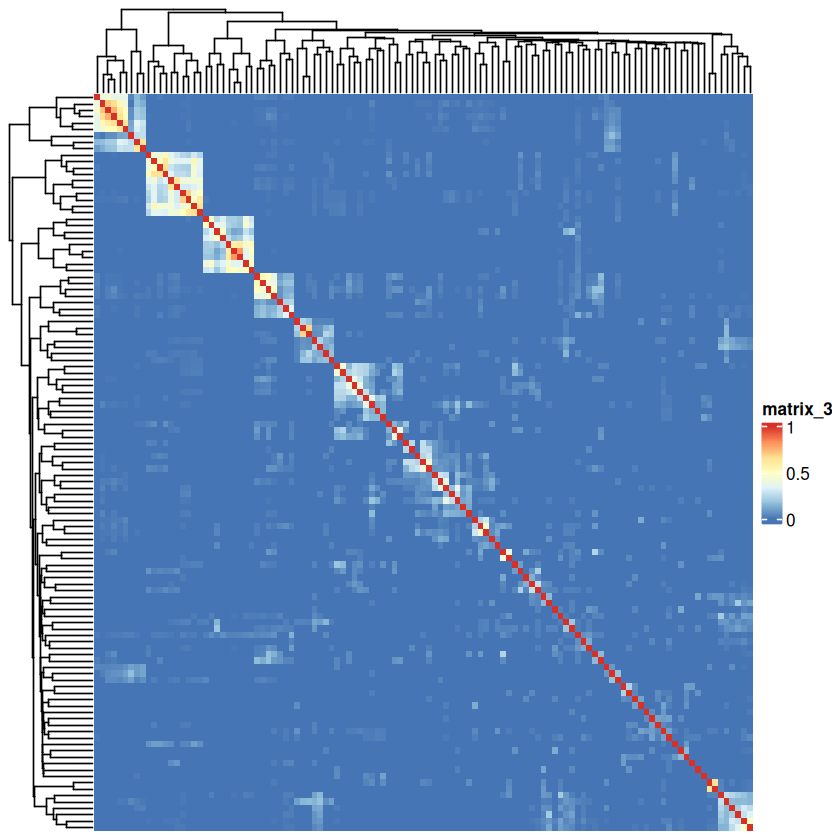

In [111]:
for (i in 1:5){
  all = unlist(Healthy_intestine_modules.list, recursive = FALSE, use.names = TRUE)
  all = lapply(all, intersect, genes.use)
  sim = sapply(all, function(x){
    sapply(all, function(y){
      length(intersect(x,y))/length(union(x,y))
    })
  })
  keep = rownames(sim)[apply(sim, 1, function(x){
    # sum(x > 0.05) >= 5
    sum(x > 0.05) >= 2
  })]
  all = all[keep]
  Healthy_intestine_modules.list = lapply(names(Healthy_intestine_modules.list), function(x){
    li = Healthy_intestine_modules.list[[x]]
    li[names(li)[paste(x,names(li),sep='.') %in% keep]]
  })
  names(Healthy_intestine_modules.list) =  names(Healthy_intestine_res_optima_L)
  ta = table(unlist(all))
  genes.use = names(ta)[ta > 1] 
  print(length(all))
}
# Filter the modules in the similarity matrix and keep those modules whose similarity coefficient with at least 5 other modules is greater than 0.05
pheatmap(sim,scale =T ,show_rownames= F, show_colnames = F)

In [112]:
sim[1:10,1:10]

Patient07_SIGAE4_ND.m_TFF3
Patient07_SIGAE4_ND.m_TFF3    1                         
Patient07_SIGAE4_ND.m_RPL4    0                         
Patient07_SIGAE4_ND.m_CFTR    0                         
Patient07_SIGAE4_ND.m_KLF6    0                         
Patient07_SIGAE4_ND.m_IFI6    0                         
Patient07_SIGAE4_ND.m_CD74    0                         
Patient07_SIGAE4_ND.m_PNRC1   0                         
Patient07_SIGAE4_ND.m_SDCCAG8 0                         
Patient07_SIGAE4_ND.m_IGKC    0                         
Patient07_SIGAE4_ND.m_GSTA2   0                         
                              Patient07_SIGAE4_ND.m_RPL4
Patient07_SIGAE4_ND.m_TFF3    0                         
Patient07_SIGAE4_ND.m_RPL4    1                         
Patient07_SIGAE4_ND.m_CFTR    0                         
Patient07_SIGAE4_ND.m_KLF6    0                         
Patient07_SIGAE4_ND.m_IFI6    0                         
Patient07_SIGAE4_ND.m_CD74    0                         
Patient07_SIGAE4_ND.m_PNRC1   0                         
Patient07_SIGAE4_ND.m_SDCCAG8 0                         
Patient07_SIGAE4_ND.m_IGKC    0                         
Patient07_SIGAE4_ND.m_GSTA2   0                         
                              Patient07_SIGAE4_ND.m_CFTR
Patient07_SIGAE4_ND.m_TFF3    0                         
Patient07_SIGAE4_ND.m_RPL4    0                         
Patient07_SIGAE4_ND.m_CFTR    1                         
Patient07_SIGAE4_ND.m_KLF6    0                         
Patient07_SIGAE4_ND.m_IFI6    0                         
Patient07_SIGAE4_ND.m_CD74    0                         
Patient07_SIGAE4_ND.m_PNRC1   0                         
Patient07_SIGAE4_ND.m_SDCCAG8 0                         
Patient07_SIGAE4_ND.m_IGKC    0                         
Patient07_SIGAE4_ND.m_GSTA2   0                         
                              Patient07_SIGAE4_ND.m_KLF6
Patient07_SIGAE4_ND.m_TFF3    0                         
Patient07_SIGAE4_ND.m_RPL4    0                         
Patient07_SIGAE4_ND.m_CFTR    0                         
Patient07_SIGAE4_ND.m_KLF6    1                         
Patient07_SIGAE4_ND.m_IFI6    0                         
Patient07_SIGAE4_ND.m_CD74    0                         
Patient07_SIGAE4_ND.m_PNRC1   0                         
Patient07_SIGAE4_ND.m_SDCCAG8 0                         
Patient07_SIGAE4_ND.m_IGKC    0                         
Patient07_SIGAE4_ND.m_GSTA2   0                         
                              Patient07_SIGAE4_ND.m_IFI6
Patient07_SIGAE4_ND.m_TFF3    0                         
Patient07_SIGAE4_ND.m_RPL4    0                         
Patient07_SIGAE4_ND.m_CFTR    0                         
Patient07_SIGAE4_ND.m_KLF6    0                         
Patient07_SIGAE4_ND.m_IFI6    1                         
Patient07_SIGAE4_ND.m_CD74    0                         
Patient07_SIGAE4_ND.m_PNRC1   0                         
Patient07_SIGAE4_ND.m_SDCCAG8 0                         
Patient07_SIGAE4_ND.m_IGKC    0                         
Patient07_SIGAE4_ND.m_GSTA2   0                         
                              Patient07_SIGAE4_ND.m_CD74
Patient07_SIGAE4_ND.m_TFF3    0                         
Patient07_SIGAE4_ND.m_RPL4    0                         
Patient07_SIGAE4_ND.m_CFTR    0                         
Patient07_SIGAE4_ND.m_KLF6    0                         
Patient07_SIGAE4_ND.m_IFI6    0                         
Patient07_SIGAE4_ND.m_CD74    1                         
Patient07_SIGAE4_ND.m_PNRC1   0                         
Patient07_SIGAE4_ND.m_SDCCAG8 0                         
Patient07_SIGAE4_ND.m_IGKC    0                         
Patient07_SIGAE4_ND.m_GSTA2   0                         
                              Patient07_SIGAE4_ND.m_PNRC1
Patient07_SIGAE4_ND.m_TFF3    0                          
Patient07_SIGAE4_ND.m_RPL4    0                          
Patient07_SIGAE4_ND.m_CFTR    0                          
Patient07_SIGAE4_ND.m_KLF6    0     

In [113]:
sub = matrix(0, nrow = length(genes.use), ncol = length(genes.use))
  rownames(sub) = genes.use
  colnames(sub) = genes.use
  for (s in names(Healthy_stomach_modules.list)){
    for (mod in Healthy_stomach_modules.list[[s]]){
      mod = intersect(mod, genes.use)
      for (x in mod){
        for (y in mod){
          sub[x,y] = sub[x,y] + 1
        }
      }
    }
  }
  diag(sub) = 0
adj_keep = sub


v_min = 2 # from 3 to 2 

s_min = 1 # from 2 to 1 

adj = adj_keep 

adj[] = (adj >= v_min) 

for (i in 1:5){ 
    keep = names(which(rowSums(adj) >= s_min))
    adj = adj[keep,keep] 
    print(dim(adj))
}

[1] 269 269
[1] 269 269
[1] 269 269
[1] 269 269
[1] 269 269


In [114]:
g = graph_from_adjacency_matrix(adj, diag = FALSE, mode = 'undirected', weighted = TRUE)
Healthy_intestine_modules = communities(cluster_infomap(g, nb.trials = 200))
names(Healthy_intestine_modules) = paste0('m_', sapply(Healthy_intestine_modules, '[', 1))


my_lengths <- sapply(Healthy_intestine_modules, length)

modules <- subset(Healthy_intestine_modules, my_lengths > 2)

 a <-lapply(Healthy_intestine_modules, list)
Healthy_intestine_modules <-lapply(a, unlist)

### Healthy intestine modules

In [115]:
Healthy_intestine_modules

$m_ADH1C
 [1] "ADH1C"    "ADIRF"    "AGR2"     "CD74"     "CKB"      "CXCL2"   
 [7] "CXCL3"    "EEF1A1"   "EEF1B2"   "FABP5"    "GDF15"    "HLA.DRA" 
[13] "HLA.DRB1" "ID1"      "KRT18"    "KRT8"     "LCN2"     "LDHB"    
[19] "LGALS3"   "LYZ"      "NACA"     "NPM1"     "PIGR"     "PTMA"    
[25] "RPL10"    "RPL10A"   "RPL11"    "RPL12"    "RPL13"    "RPL13A"  
[31] "RPL15"    "RPL17"    "RPL18A"   "RPL21"    "RPL22"    "RPL23"   
[37] "RPL26"    "RPL29"    "RPL3"     "RPL30"    "RPL31"    "RPL32"   
[43] "RPL34"    "RPL35"    "RPL35A"   "RPL36A"   "RPL37"    "RPL37A"  
[49] "RPL39"    "RPL4"     "RPL41"    "RPL5"     "RPL6"     "RPL7"    
[55] "RPLP1"    "RPLP2"    "RPS12"    "RPS13"    "RPS14"    "RPS15A"  
[61] "RPS17"    "RPS18"    "RPS19"    "RPS2"     "RPS20"    "RPS21"   
[67] "RPS23"    "RPS24"    "RPS27"    "RPS27A"   "RPS28"    "RPS29"   
[73] "RPS3"     "RPS3A"    "RPS4X"    "RPS4Y1"   "RPS5"     "RPS6"    
[79] "RPS7"     "RPS8"     "RPSA"     "S100A11"  "SMIM24"   "SNHG8"   
[85] "SPDEF"    "TMSB10"   "TMSB4X"   "TSPAN1"   "TSPAN8"  

$m_AKR1B10
 [1] "AKR1B10" "AKR1C1"  "AKR1C3"  "BCAS1"   "CA2"     "CEACAM5" "CTSE"   
 [8] "FABP1"   "FCGBP"   "GSN"     "IFI27"   "KRT19"   "KRT20"   "LGALS4" 
[15] "MGST3"   "MUC1"    "PHGR1"   "PLAC8"   "REG4"    "RHOC"    "RNASE1" 
[22] "S100A6"  "S100P"   "SPINK1"  "TFF1"    "TXN"    

$m_ALDH1A1
 [1] "ALDH1A1"  "APOA1"    "ATF3"     "ATP1B1"   "BTG2"     "C12orf75"
 [7] "CD24"     "CHGA"     "CHGB"     "CLDN4"    "CPE"      "DUSP1"   
[13] "EGR1"     "FOSB"     "GADD45B"  "GADD45G"  "H1.10"    "H3.3B"   
[19] "HEPACAM2" "HLA.B"    "IDS"      "IER2"     "IFI6"     "IRF1"    
[25] "JUNB"     "MAFB"     "MDK"      "MS4A8"    "MSLN"     "NEUROD1" 
[31] "NR4A1"    "PBXIP1"   "PCSK1N"   "RASD1"    "SCG5"     "SCGN"    
[37] "SEC11C"   "SERPINA1" "SNHG25"   "TFF3"     "TM4SF4"   "TMEM176A"
[43] "TMEM176B" "TUBA1A"   "WSB1"     "ZFP36"   

$m_ANKRD36C
 [1] "ANKRD36C"    "AREG"        "ARL14"       "C15orf48"    "CD55"       
 [6] "CSKMT"       "DNAJA1"      "DNAJB1"      "ELF3"        "H2BC8"      
[11] "H4C3"        "HES1"        "HEXIM1"      "HSP90AA1"    "HSPA1A"     
[16] "HSPA1B"      "HSPB1"       "HSPH1"       "ID2"         "INTS6"      
[21] "JUN"         "KLF6"        "LDLR"        "MALAT1"      "NEAT1"      
[26] "PHLDA2"      "PMAIP1"      "PPP1R15A"    "RHOB"        "RND3"       
[31] "SLC38A2"     "SOX4"        "STX5.DT"     "TCIM"        "TENT5A"     
[36] "THUMPD3.AS1" "TLE4"        "UBC"         "WFDC2"      

$m_ANKRD37
[1] "ANKRD37"  "CCN2"     "FOS"      "FOXA3"    "HBEGF"    "ID3"      "KCNQ1OT1"
[8] "MYLIP"   

$m_ARL6IP1
 [1] "ARL6IP1" "CENPF"   "CENPW"   "CENPX"   "CKS1B"   "CKS2"    "DEK"    
 [8] "DTYMK"   "DUT"     "H2AX"    "H2AZ1"   "HELLS"   "HMGB1"   "HMGB2"  
[15] "HMGN2"   "IER3"    "MCM7"    "NUCKS1"  "PCLAF"   "PCNA"    "PTTG1"  
[22] "RAN"     "SMC4"    "STMN1"   "TK1"     "TOP2A"   "TUBA1B"  "TUBB"   
[29] "TUBB4B"  "UBE2S"   "ZWINT"  

$m_AZGP1
 [1] "AZGP1"   "B2M"     "DEFB1"   "ERO1B"   "HSPA5"   "IDH2"    "MT1E"   
 [8] "MT1F"    "MT1G"    "MT1H"    "MT1M"    "MT1X"    "MT2A"    "N4BP2L2"
[15] "NUPR1"   "PDK4"    "RARRES2" "REG1A"   "REG3A"  

$m_COX1
[1] "COX1" "COX2" "CYTB" "ND2"  "ND3"  "ND4" 

$m_NCOA7
[1] "NCOA7"  "NFKBIA"

$m_PTP4A1
[1] "PTP4A1"  "RGMB"    "SLC12A2"

In [118]:
saveRDS(Healthy_stomach_modules, file = "../04_Test_NMF_Program_0120/01_Healthy_stomach_modules.rds")

saveRDS(Healthy_intestine_modules, file = "../04_Test_NMF_Program_0120/01_Healthy_intestine_modules.rds")


In [120]:
SC_Columnar <-readRDS('./01_SC_Columnar.rds')

### Barrett esophagus

In [129]:
freq_table <- table(SC_Columnar$disease, SC_Columnar$sample_name)

BE_sample_names <- names(freq_table["Barrett esophagus", ][freq_table["Barrett esophagus", ] > 0])
BE_sample_names

[1] "Patient03_SIGAB5_BSCJ" "Patient03_SIGAC5_BE"   "Patient07_SIGAB4_BSCJ"
 [4] "Patient07_SIGAC4_BE"   "Patient09_SIGAE9_BSCJ" "Patient09_SIGAF9_BE"  
 [7] "Patient12_SIGAC3_GM"   "Patient18_SIGAA3_GM"   "Patient19_SIGAB3_BE"  
[10] "Patient20_SIGAC3_GM"

In [134]:
table(SC_Columnar$disease, SC_Columnar$Tissue_in_paper)

                               
                                BE-IM  BSCJ   CAG   CIM Colon  E-GM   GIM Ileum
  gastritis                         0     0 15936     0     0     0     0     0
  Barrett esophagus              2198  1220     0     0     0  3160     0     0
  normal                            0     0     0   946  4220     0     0  6737
  gastric intestinal metaplasia     0     0     0  3192     0     0 16711     0
                               
                                  NAG    ND   NGB   NGC  NSCJ Rectum
  gastritis                      5720     0     0     0     0      0
  Barrett esophagus                 0     0     0     0     0      0
  normal                            0  3199  2636  7894  2603   3150
  gastric intestinal metaplasia     0     0     0     0     0      0

In [135]:
BE_res_optima_L <- res_optima_L[BE_sample_names]

#subset
BE_res_optima_L <- Filter(Negate(is.null), BE_res_optima_L)

BE_modules.list = lapply(BE_res_optima_L, NMFToModules)

In [136]:
all = unlist(BE_modules.list, recursive = FALSE, use.names = FALSE)

names(all) = unlist(sapply(BE_modules.list, names))
ta = table(unlist(all))
genes.use = names(ta)[ta > 1]

[1] 125
[1] 124
[1] 124
[1] 124
[1] 124


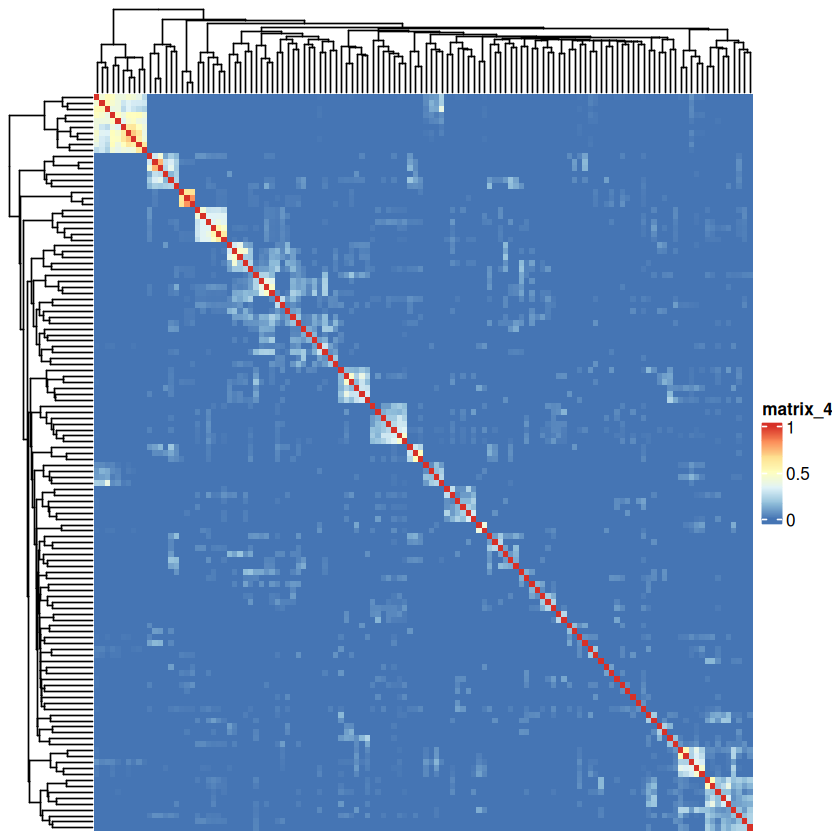

In [137]:
for (i in 1:5){
  all = unlist(BE_modules.list, recursive = FALSE, use.names = TRUE)
  all = lapply(all, intersect, genes.use)
  sim = sapply(all, function(x){
    sapply(all, function(y){
      length(intersect(x,y))/length(union(x,y))
    })
  })
  keep = rownames(sim)[apply(sim, 1, function(x){
    # sum(x > 0.05) >= 5
    sum(x > 0.05) >= 2
  })]
  all = all[keep]
  BE_modules.list = lapply(names(BE_modules.list), function(x){
    li = BE_modules.list[[x]]
    li[names(li)[paste(x,names(li),sep='.') %in% keep]]
  })
  names(BE_modules.list) =  names(BE_res_optima_L)
  ta = table(unlist(all))
  genes.use = names(ta)[ta > 1] 
  print(length(all))
}
# Filter the modules in the similarity matrix and keep those modules whose similarity coefficient with at least 5 other modules is greater than 0.05
pheatmap(sim,scale =T ,show_rownames= F, show_colnames = F)

In [141]:
sub = matrix(0, nrow = length(genes.use), ncol = length(genes.use))
  rownames(sub) = genes.use
  colnames(sub) = genes.use
  for (s in names(BE_modules.list)){
    for (mod in BE_modules.list[[s]]){
      mod = intersect(mod, genes.use)
      for (x in mod){
        for (y in mod){
          sub[x,y] = sub[x,y] + 1
        }
      }
    }
  }
  diag(sub) = 0
adj_keep = sub


v_min = 2 # from 3 to 2 

s_min = 1 # from 2 to 1 

adj = adj_keep 

adj[] = (adj >= v_min) 

for (i in 1:5){ 
    keep = names(which(rowSums(adj) >= s_min))
    adj = adj[keep,keep] 
    print(dim(adj))
}

[1] 624 624
[1] 624 624
[1] 624 624
[1] 624 624
[1] 624 624


In [143]:
g = graph_from_adjacency_matrix(adj, diag = FALSE, mode = 'undirected', weighted = TRUE)
BE_modules = communities(cluster_infomap(g, nb.trials = 200))
names(BE_modules) = paste0('m_', sapply(BE_modules, '[', 1))


my_lengths <- sapply(BE_modules, length)

modules <- subset(BE_modules, my_lengths > 2)

 a <-lapply(BE_modules, list)
BE_modules <-lapply(a, unlist)

### BE modules

In [35]:
BE_modules

ERROR: Error: object 'BE_modules' not found


In [145]:
saveRDS(BE_modules, file = "../04_Test_NMF_Program_0120/01_BE_modules.rds")

In [149]:
healthy_stomach_samples <- names(table(Healthy_stomach$sample_name))

healthy_intestine_samples <- names(table(Healthy_intestine$sample_name))
                                                                                                        
samplename_list <- list(Healthy_stomach = healthy_stomach_samples,
                Healthy_intestine = healthy_intestine_samples,
                BE_sample_names = BE_sample_names)

In [152]:
samplename_list

$Healthy_stomach
 [1] "P5846_normal"           "P5866_normal_rep1"      "P5866_normal_rep2"     
 [4] "P5931_normal_rep1"      "P5931_normal_rep2"      "P6207_normal"          
 [7] "P6342_normal"           "P6592_normal"           "P6649_normal"          
[10] "P6709_normal"           "Patient01_SIGAF2_NSCJ"  "Patient01_SIGAG2_NG"   
[13] "Patient02_SIGAD9_NSCJ"  "Patient02_SIGAE9_NG"    "Patient03_SIGAD5_NG"   
[16] "Patient05_SIGAG11_NSCJ" "Patient06_Karol-C_NSCJ" "Patient06_Karol-E_NG"  
[19] "Patient07_SIGAD4_NG"    "Patient08_SIGAE7_NSCJ"  "Patient08_SIGAF7_NG"   
[22] "Patient09_SIGAG9_NG"    "Patient10_SIGAB5_NSCJ"  "Patient10_SIGAC5_NG"   
[25] "Patient13_SIGAD8_NSCJ"  "Patient13_SIGAE8_NG"    "Patient14_SIGAF8_NG"   
[28] "Patient15_SIGAG11_NSCJ" "Patient15_SIGAH11_NG"   "Patient16_SIGAC1_NG"   
[31] "Patient17_SIGAH7_NG"    "Patient21_SIGAC1_NG"   

$Healthy_intestine
 [1] "Patient07_SIGAE4_ND" "Patient08_SIGAG7_ND" "Patient09_SIGAH9_ND"
 [4] "Patient12_SIGAE3_ND" "SRR8513794"          "SRR8513795"         
 [7] "SRR8513796"          "SRR8513797"          "SRR8513798"         
[10] "SRR8513799"         

$BE_sample_names
 [1] "Patient03_SIGAB5_BSCJ" "Patient03_SIGAC5_BE"   "Patient07_SIGAB4_BSCJ"
 [4] "Patient07_SIGAC4_BE"   "Patient09_SIGAE9_BSCJ" "Patient09_SIGAF9_BE"  
 [7] "Patient12_SIGAC3_GM"   "Patient18_SIGAA3_GM"   "Patient19_SIGAB3_BE"  
[10] "Patient20_SIGAC3_GM"

In [153]:
saveRDS(samplename_list, file = "../04_Test_NMF_Program_0120/02_samplename_list.rds")

### Calculating AUCell scores

In [4]:
split_list <- readRDS('./01_split_list.rds')

samplename_list <- readRDS("../04_Test_NMF_Program_0120/02_samplename_list.rds")

In [5]:
Healthy_stomach_obj <-  split_list[samplename_list$Healthy_stomach]

Healthy_stomach_obj <- merge(Healthy_stomach_obj[[1]],Healthy_stomach_obj[-1])

In [9]:
Healthy_stomach_obj<- NormalizeData(Healthy_stomach_obj, verbose = FALSE) %>% 
                    FindVariableFeatures( nfeatures = 3000,
                                     assay = 'RNA',
                                     selection.method = "vst") 

all.genes <- rownames(Healthy_stomach_obj)

Healthy_stomach_obj <- ScaleData(Healthy_stomach_obj ,features = all.genes)  %>%
                        ScaleData( vars.to.regress = "MT.prop")  %>%
                        RunPCA(npcs = 30,features = VariableFeatures(object = Healthy_stomach_obj)) 

DefaultAssay(Healthy_stomach_obj) <- 'RNA'

Healthy_stomach_obj <- RunHarmony(Healthy_stomach_obj,reduction = "pca",group.by.vars = "sample_name",reduction.save = "harmony") %>%
                    FindNeighbors(data,dims = 1:15, reduction = 'harmony') %>%
                    RunUMAP( dims = 1:15, reduction = 'harmony')

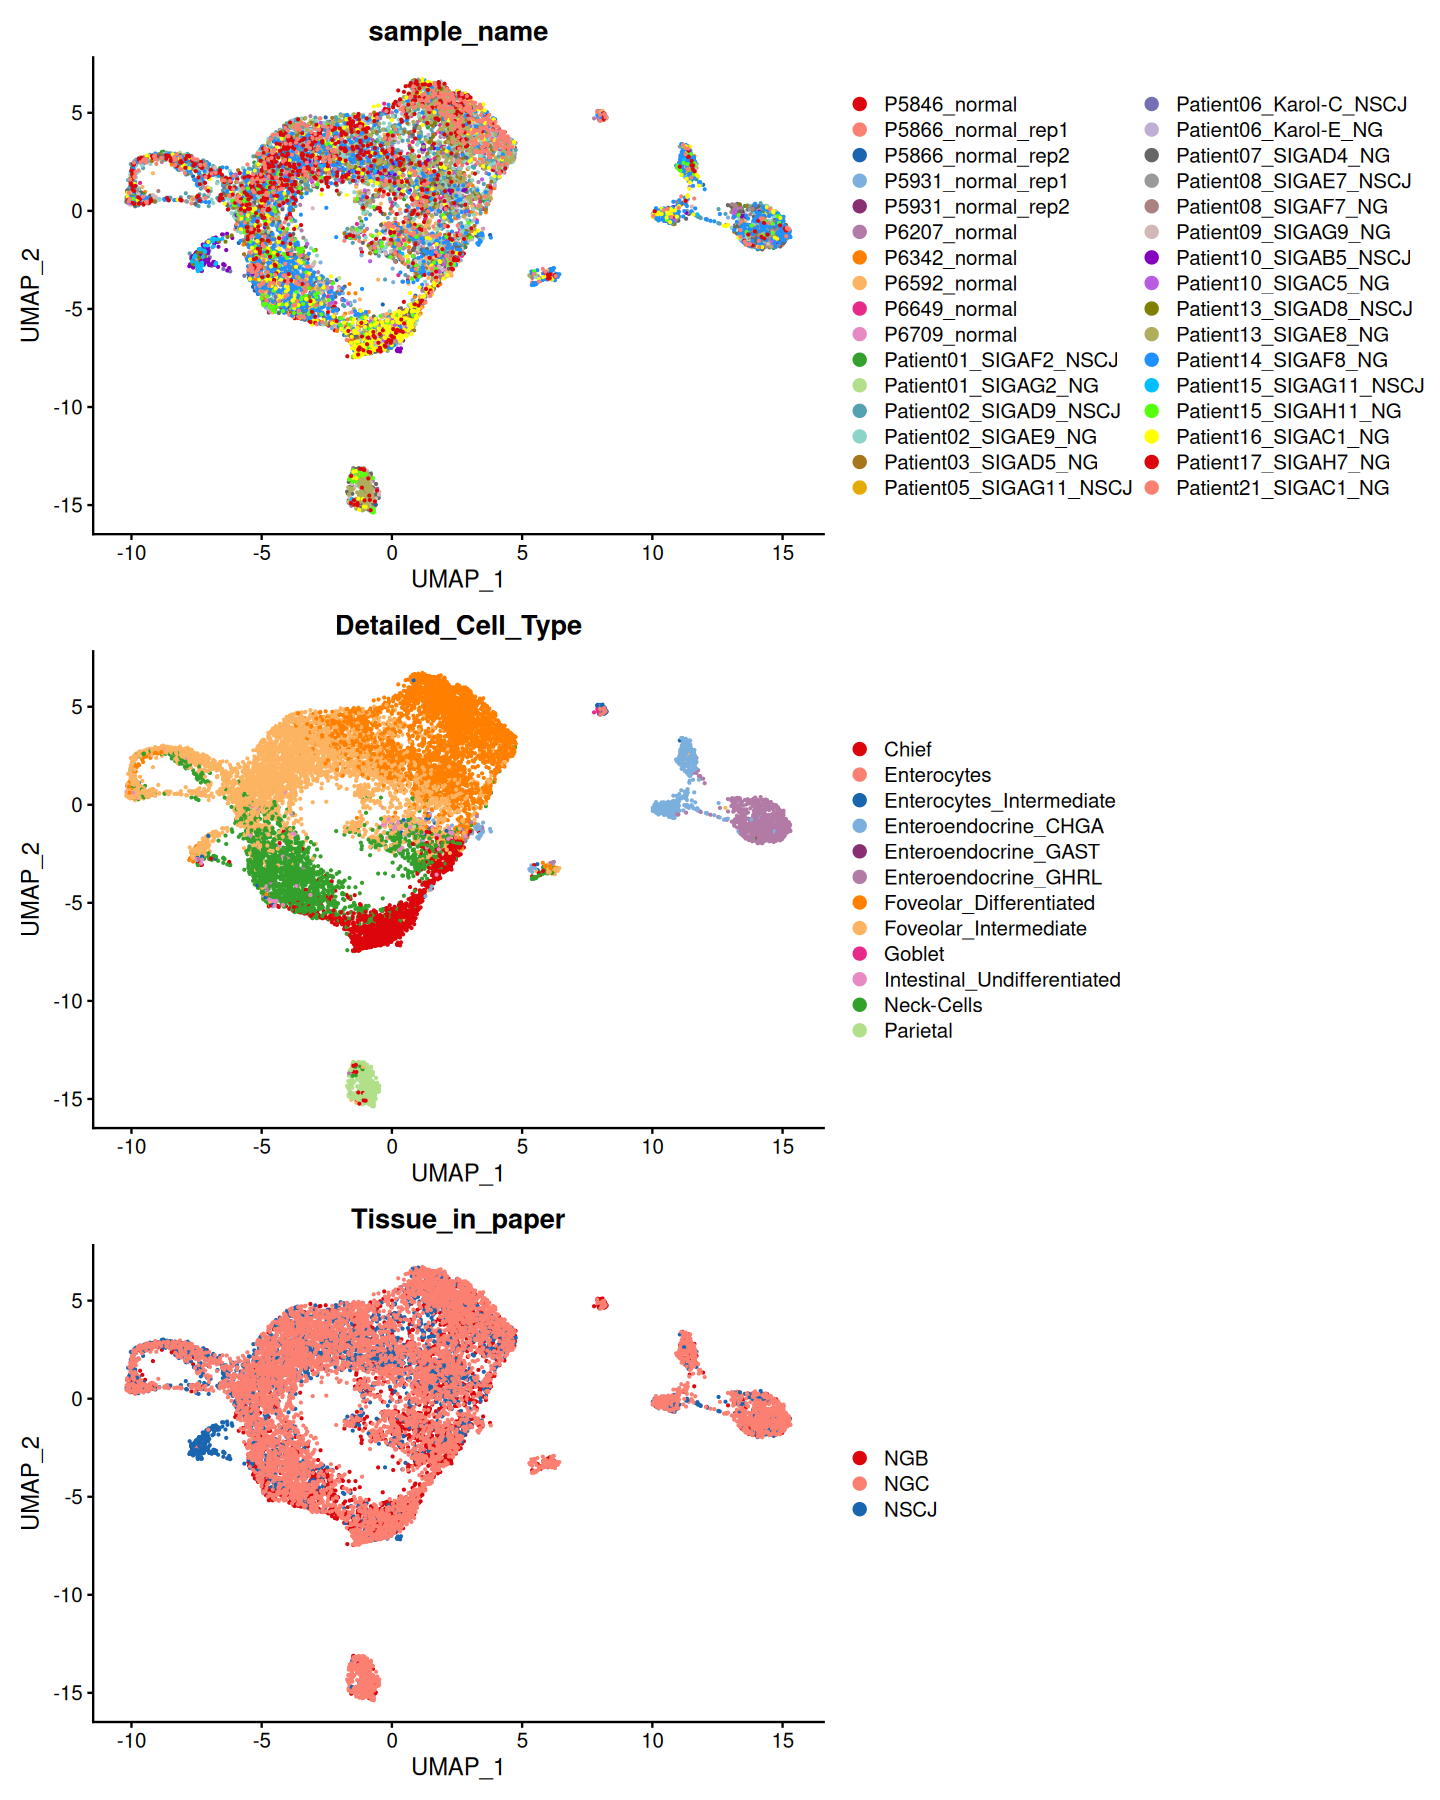

In [13]:
options(repr.plot.width = 12, repr.plot.height=15)
DimPlot(Healthy_stomach_obj,label = F, group.by =c('sample_name', 'Detailed_Cell_Type','Tissue_in_paper'),reduction = c("umap"),cols =rep(cluster_cols,3),ncol = 1 )

In [14]:
Healthy_stomach_modules <-readRDS("../04_Test_NMF_Program_0120/01_Healthy_stomach_modules.rds")

In [15]:
Healthy_stomach_modules

$m_ABCC3
 [1] "ABCC3"       "ACADVL"      "ANKRD11"     "ANKRD36C"    "ANXA1"      
 [6] "ARGLU1"      "CAPN8"       "CDC42BPA"    "CRACR2B"     "CSKMT"      
[11] "CSRNP2"      "CYP3A5"      "DDX17"       "EIF4A1"      "ELF3"       
[16] "ELL2"        "FAM133B"     "FLNB"        "FMN1"        "FUS"        
[21] "H2BC8"       "HES1"        "HEXIM1"      "HSPA5"       "INTS6"      
[26] "KANSL1"      "KCNQ1OT1"    "LIPH"        "MALAT1"      "MEPCE"      
[31] "NEAT1"       "PARP14"      "PLCG2"       "RAB11FIP1"   "RICTOR"     
[36] "RND3"        "SAT1"        "SCNN1A"      "SLC38A2"     "SOX4"       
[41] "SPIRE2"      "SPRR3"       "SQSTM1"      "STX5.DT"     "SYTL2"      
[46] "TAPBP"       "TCIM"        "THUMPD3.AS1" "TLE4"        "TTC14"      
[51] "VMP1"        "ZFP36L2"    

$m_ABCC5
[1] "ABCC5" "ABHD2" "INF2" 

$m_ABHD5
 [1] "ABHD5"    "ADM"      "ALDH3A1"  "ANKRD37"  "ANXA4"    "AREG"    
 [7] "ARL14"    "ARL5B"    "BIRC3"    "CBX4"     "CCN1"     "CCN2"    
[13] "CEBPD"    "CHP1"     "CITED2"   "CXCL2"    "CXCL8"    "DNAJA1"  
[19] "DNAJA4"   "DNAJB1"   "EFNA1"    "FOSB"     "GADD45B"  "GPRC5A"  
[25] "HBEGF"    "HSP90AA1" "HSPA1A"   "HSPA1B"   "HSPA6"    "HSPB1"   
[31] "HSPH1"    "ID2"      "ID3"      "IER3"     "IRF1"     "ITPKC"   
[37] "JDP2"     "JUND"     "KLF2"     "KLF6"     "LARP4"    "LDLR"    
[43] "LTF"      "MAFF"     "MTHFD2"   "MYLIP"    "NAMPT"    "NCOA7"   
[49] "NFKBIA"   "NFKBIZ"   "ODC1"     "PHLDA2"   "PLK2"     "PMAIP1"  
[55] "PPP1R15A" "PTP4A1"   "RAP2B"    "RHOB"     "RND1"     "SDC4"    
[61] "SELENOW"  "SERTAD1"  "SOCS3"    "SPDEF"    "TACSTD2"  "TENT5A"  
[67] "TGIF1"    "TNFAIP3"  "TOB1"     "UBB"      "UBC"      "WEE1"    
[73] "YPEL2"    "ZBTB43"   "ZC3HAV1"  "ZFAND2A"  "ZFP36"    "ZFP36L1" 

$m_ACADM
  [1] "ACADM"      "ACAT1"      "ACO2"       "ADA"        "AKR7A3"    
  [6] "ALDH1A1"    "ATP1B1"     "ATP4A"      "ATP4B"      "ATP5F1A"   
 [11] "ATP5F1B"    "ATP5F1C"    "ATP5MC1"    "ATP5MC3"    "ATP5ME"    
 [16] "ATP5MG"     "ATP5MJ"     "ATP5MK"     "ATP5PB"     "ATP5PD"    
 [21] "ATP5PF"     "ATP5PO"     "BNIP3"      "BOLA3"      "BSG"       
 [26] "CALM1"      "CBLIF"      "CHCHD10"    "CKB"        "CLIC6"     
 [31] "COA3"       "COMMD6"     "COX17"      "COX5A"      "COX5B"     
 [36] "COX6B1"     "COX7A2"     "COX7B"      "COX7C"      "CYC1"      
 [41] "CYCS"       "DDT"        "DLD"        "ECHS1"      "ECI2"      
 [46] "ESRRG"      "EZR"        "FABP3"      "FTH1"       "FXYD4"     
 [51] "G0S2"       "GHITM"      "GLOD4"      "GLUL"       "GOT1"      
 [56] "GPR155"     "GPX4"       "GSTA1"      "HADHB"      "HIBADH"    
 [61] "IDH2"       "INSIG1"     "ISCU"       "KCNE2"      "KIAA1191"  
 [66] "LDHB"       "MDH1"       "MDH2"       "MPC1"       "MPC2"      
 [71] "MRPL41"     "NDUFA1"     "NDUFA10"    "NDUFA4"     "NDUFA5"    
 [76] "NDUFA6"     "NDUFAB1"    "NDUFB7"     "NDUFC1"     "NDUFS2"    
 [81] "NDUFS3"     "NDUFS7"     "NDUFS8"     "NDUFV1"     "NFE2L2"    
 [86] "NHERF1"     "NR0B2"      "PBLD"       "PDHA1"      "PHLDA1"    
 [91] "PLEKHB2"    "PRDX2"      "PRDX5"      "PXMP2"      "RAB4A"     
 [96] "REXO2"      "SDHB"       "SDHC"       "SKAP2"      "SLC25A3"   
[101] "SLC25A4"    "SLC25A5"    "SOD1"       "SPINT1.AS1" "STX12"     
[106] "SUCLG1"     "SUCLG2"     "TBCA"       "TM7SF2"     "TPD52L1"   
[111] "TPI1"       "UQCR11"     "UQCRB"      "UQCRC1"     "UQCRC2"    
[116] "UQCRFS1"    "UQCRH"      "UQCRQ"      "VDAC1"      "VRK1"      

$m_ACOT13
[1] "ACOT13"  "DUSP4"   "H1.2"    "TAX1BP1"

$m_ACOT7
  [1] "ACOT7"     "ACSL1"     "APLP1"     "APOA1"     "ARFGEF3"   "ATF3"     
  [7] "B2M"       "BCAM"      "BEX1"      "BEX2"      "BEX3"      "BHMT"     
 [13] "BTG2"      "C12orf75"  "C2CD4B"    "CACNA1A"   "CALD1"     "CAMK2N1"  
 [19] "CBX6"      "CD24"      "CEP126"    "CEP164"    "CFC1"      "CHGA"     
 [25] "CHGB"      "CIRBP"     "CITED4"    "CLDN4"     "CLU"       "CPE"      
 [31] "CRYBA2"    "DDX5"      "DEPP1"     "DPP7"      "DUSP1"     "E

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



 min   1%   5%  10%  50% 100% 
  61  218  328  418 1406 7960 


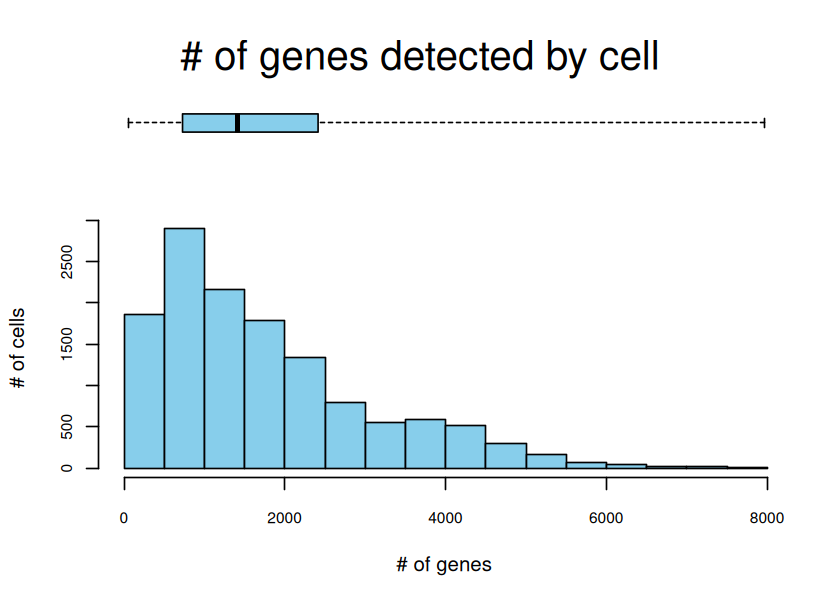

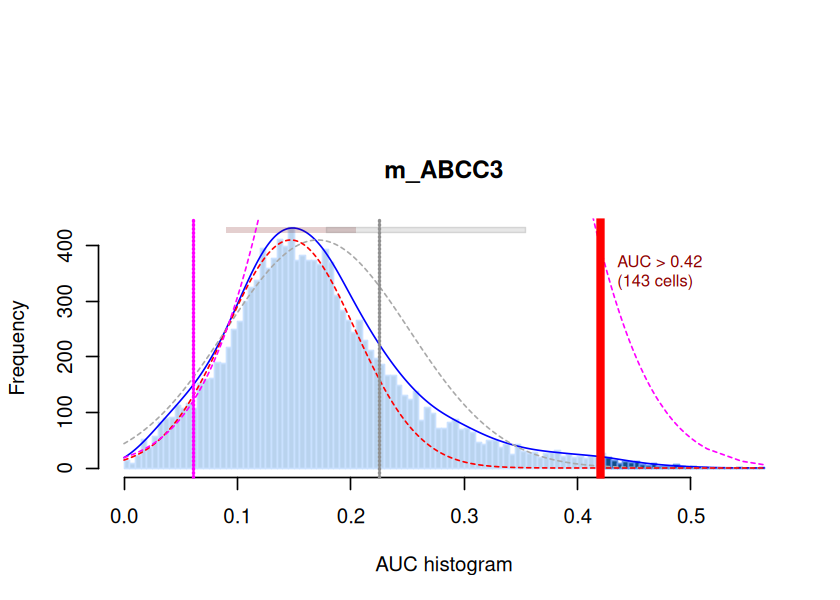

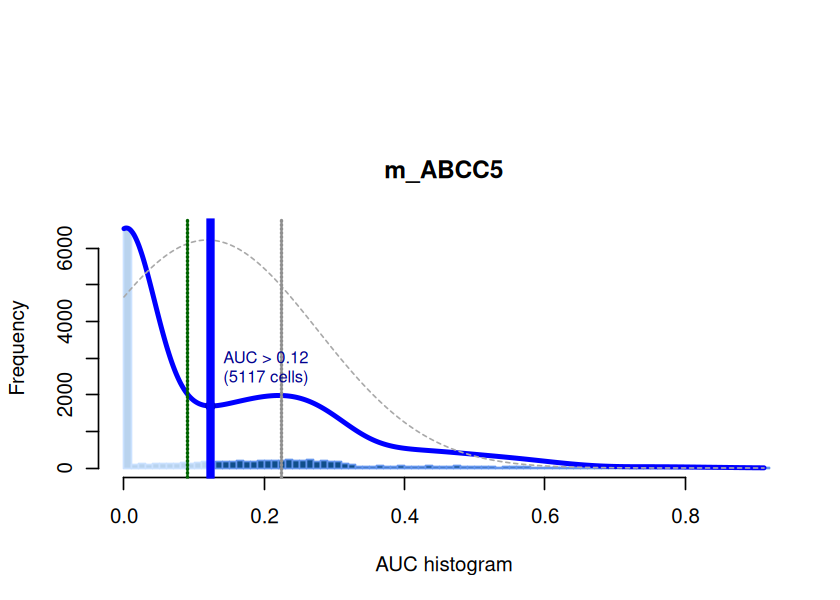

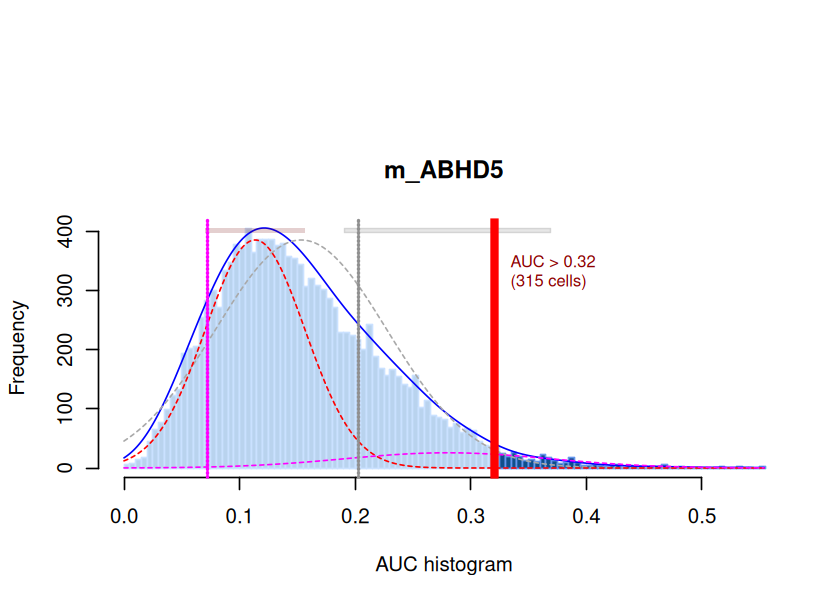

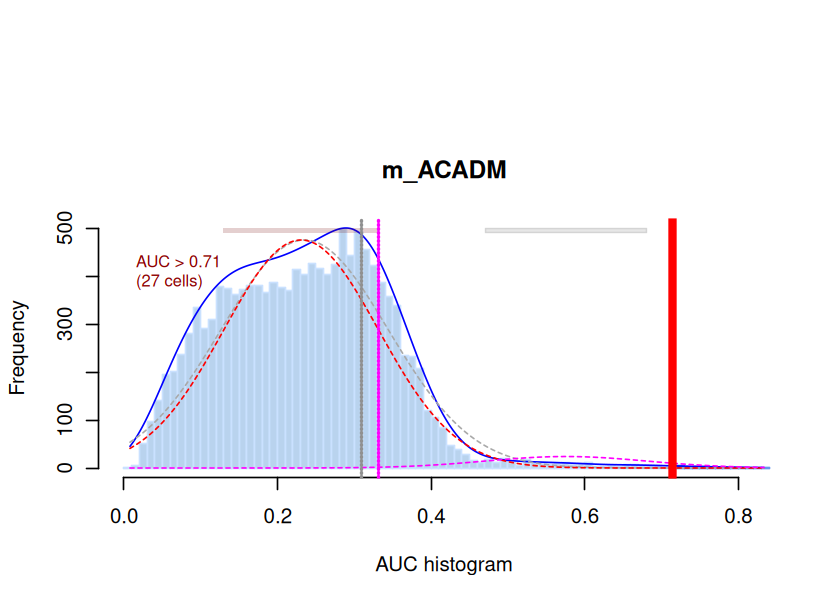

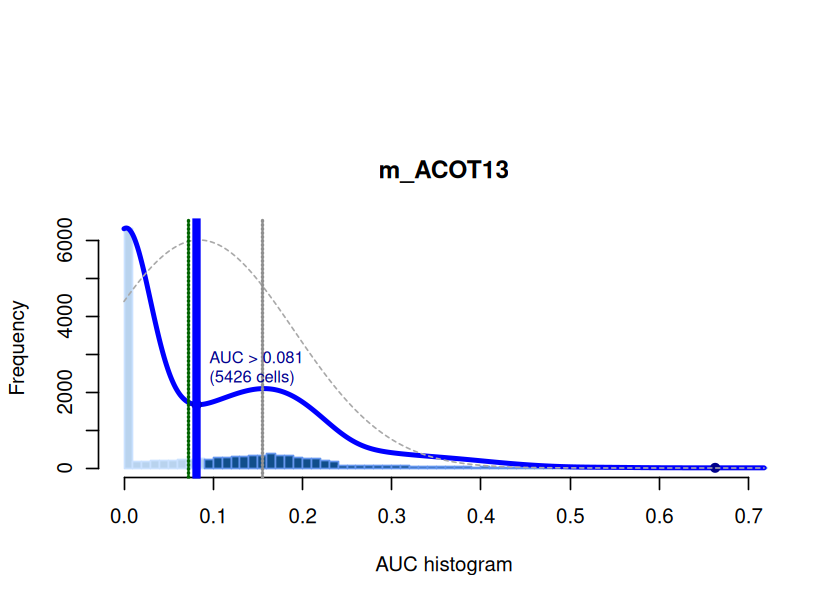

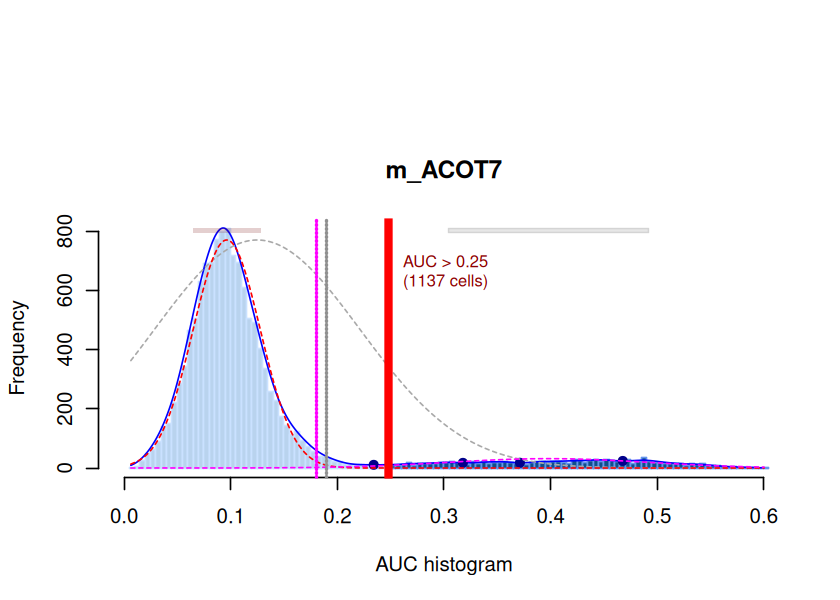

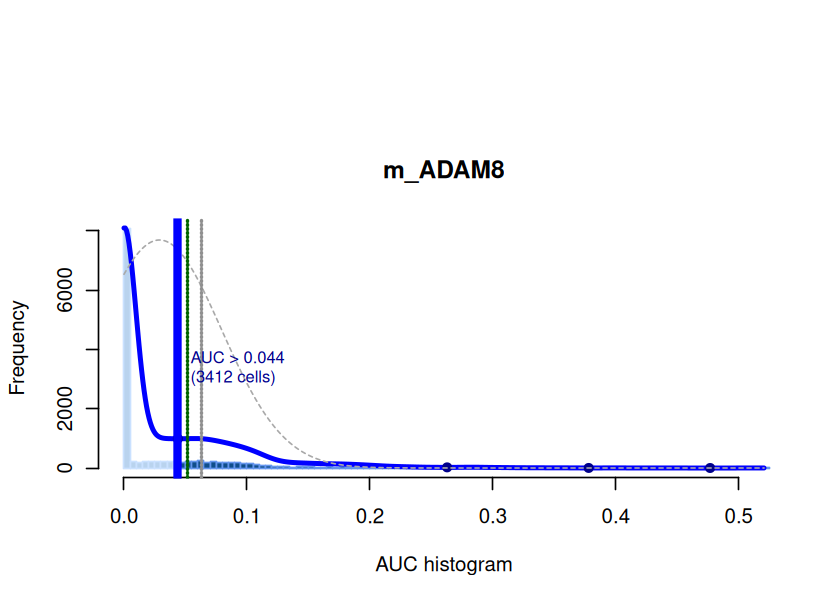

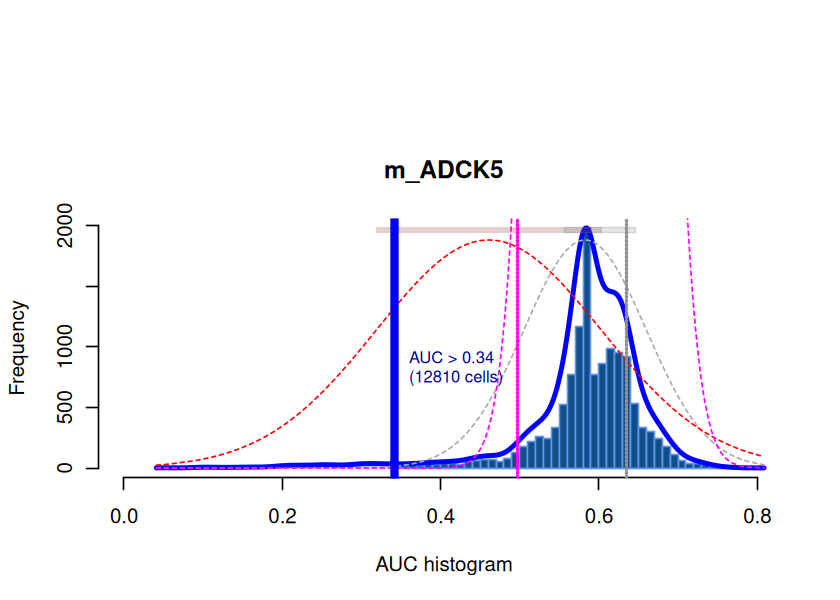

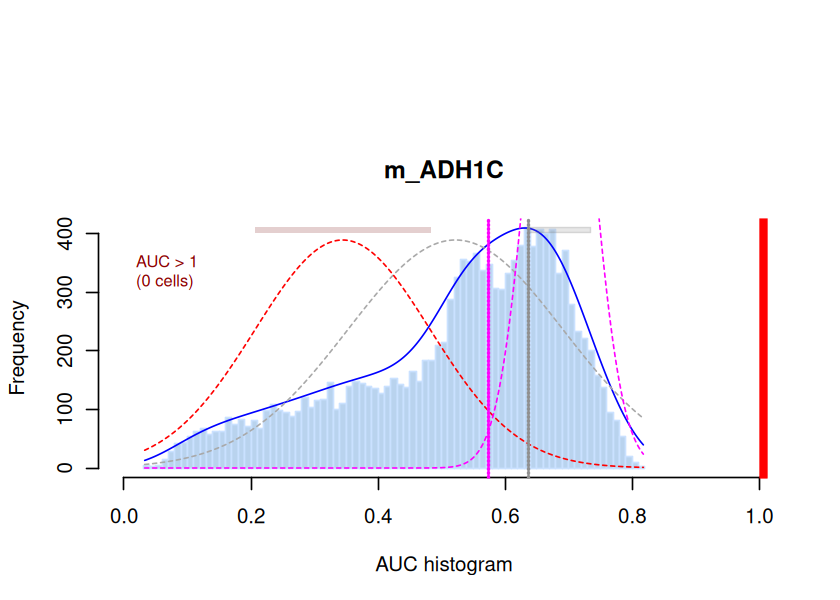

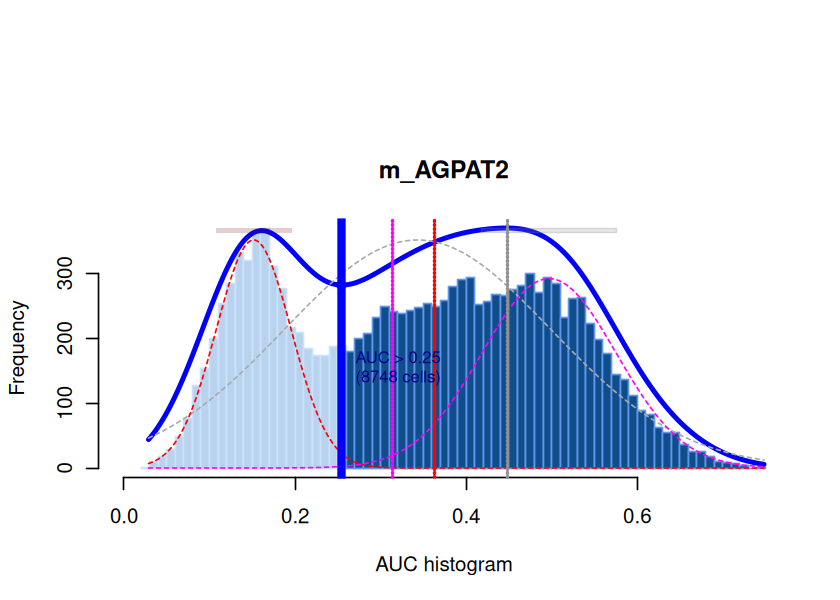

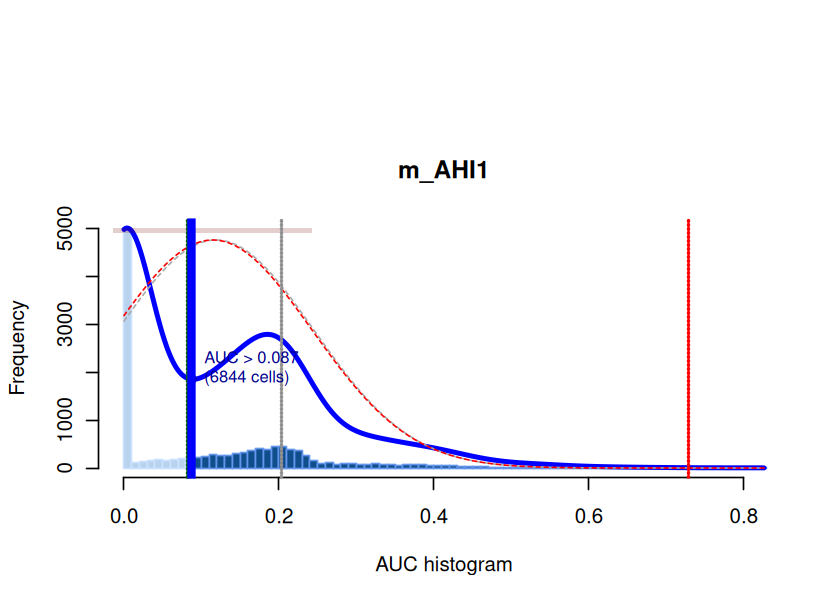

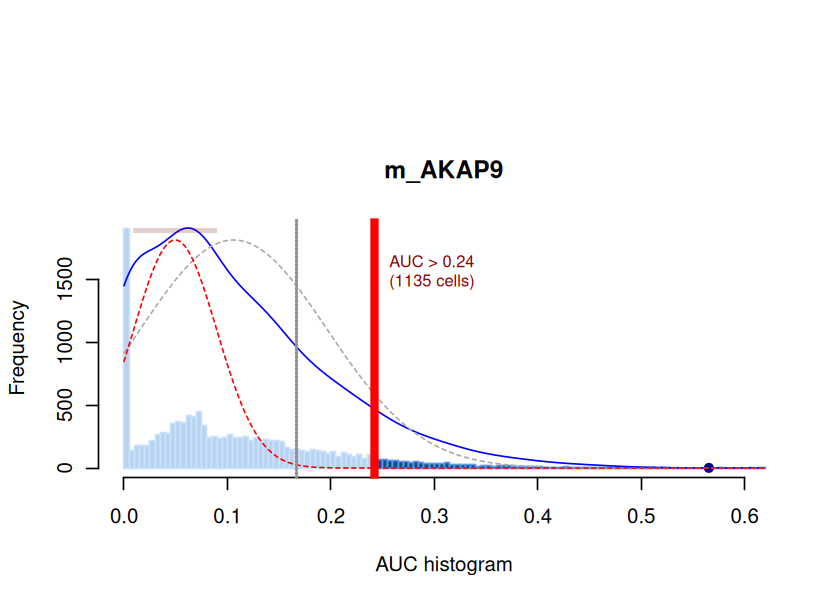

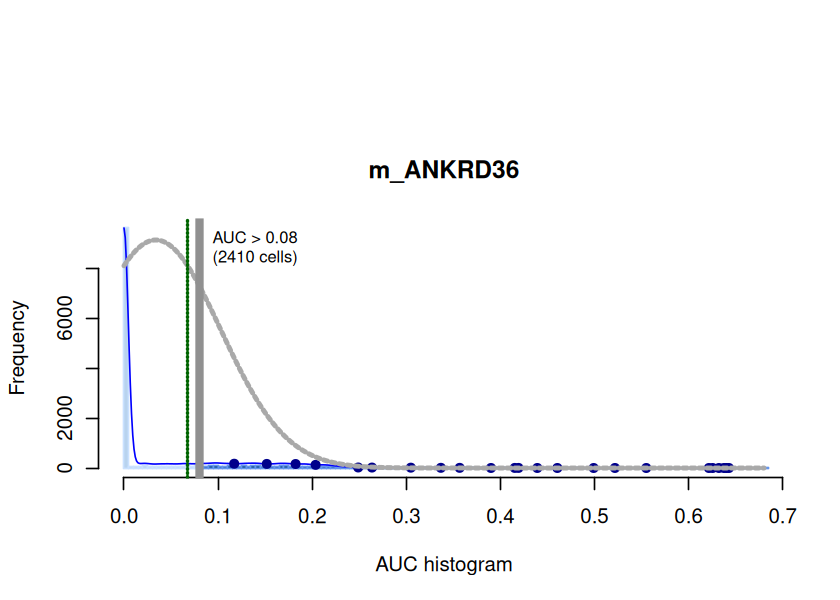

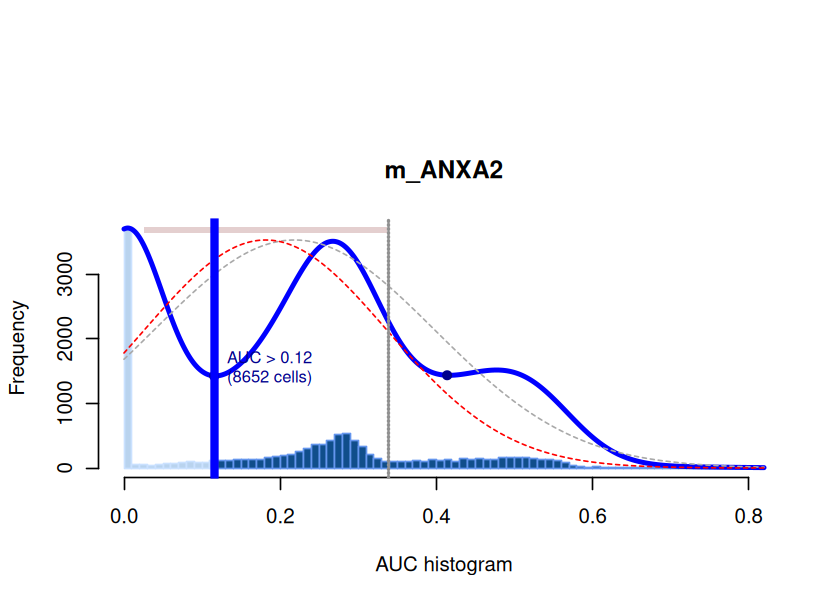

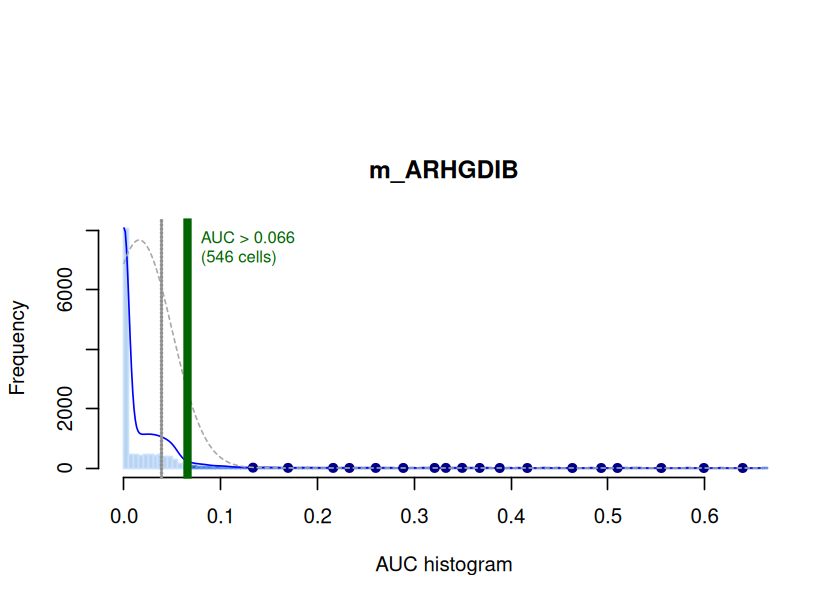

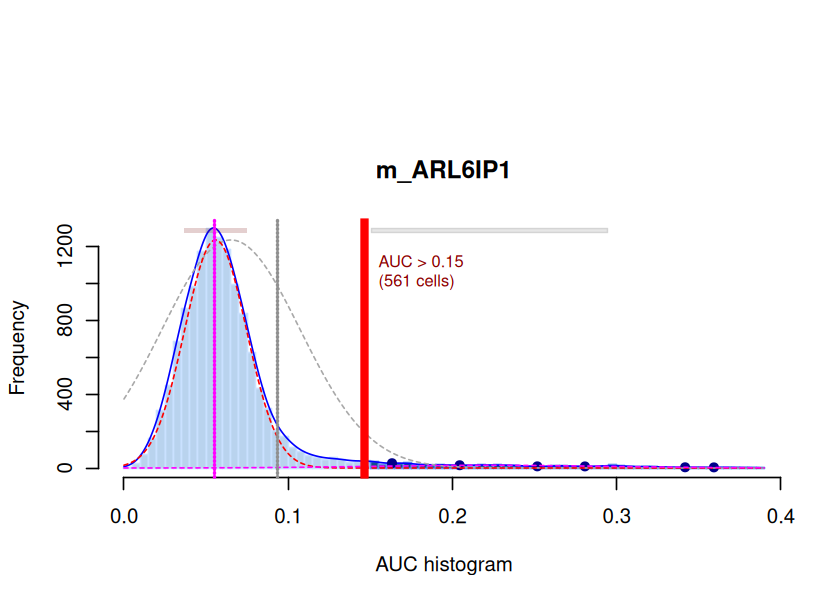

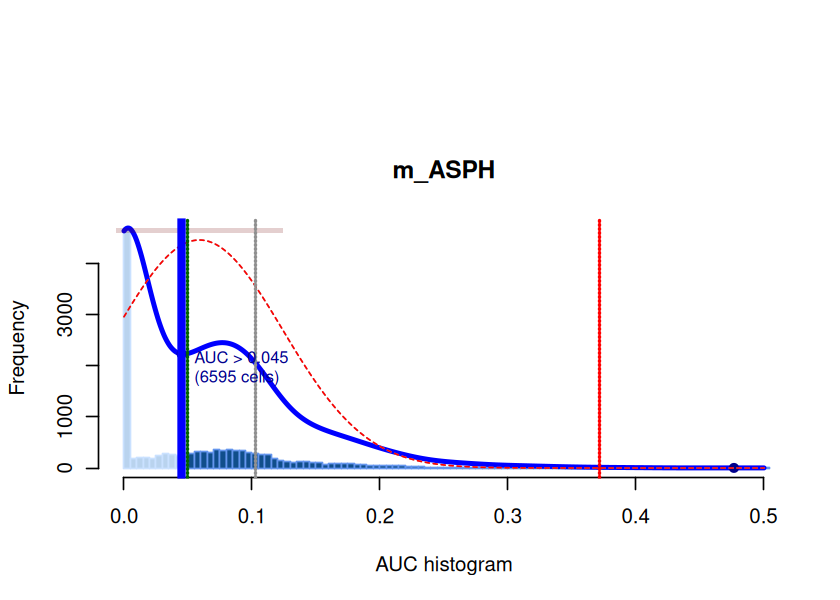

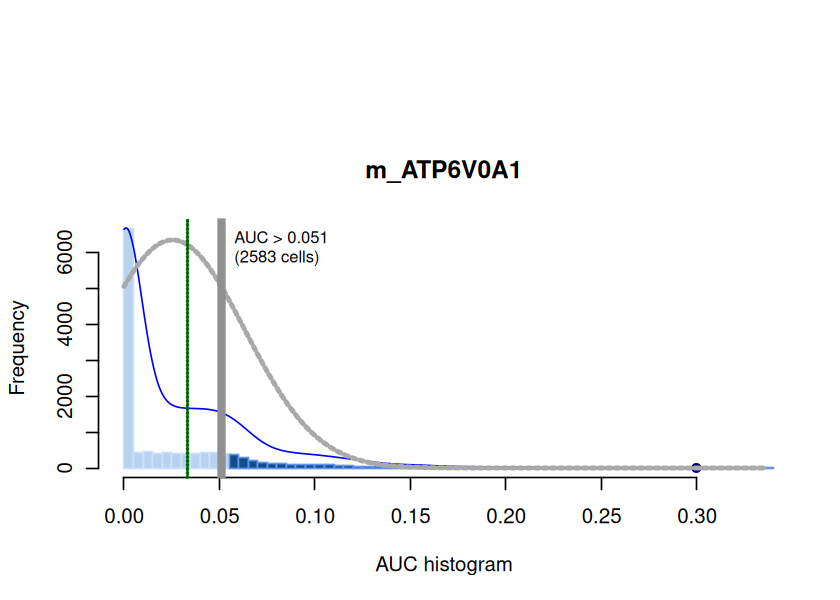

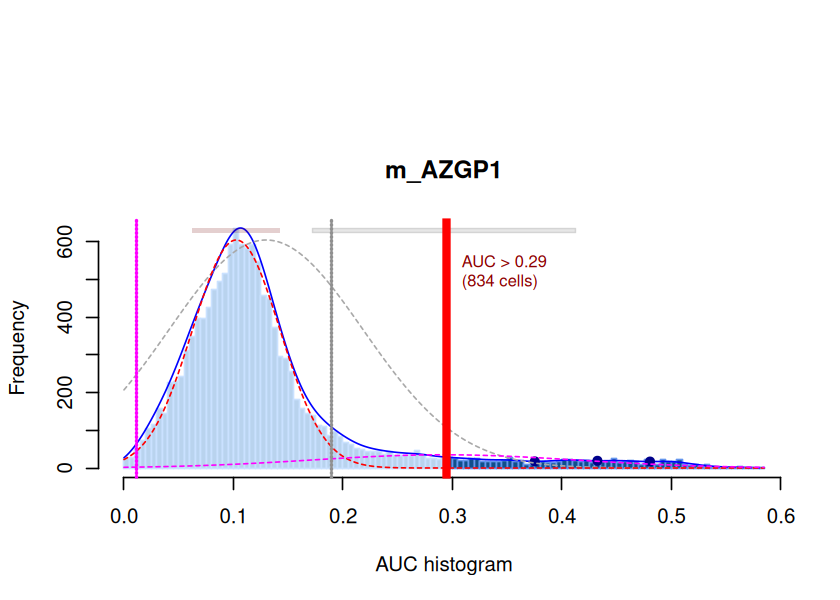

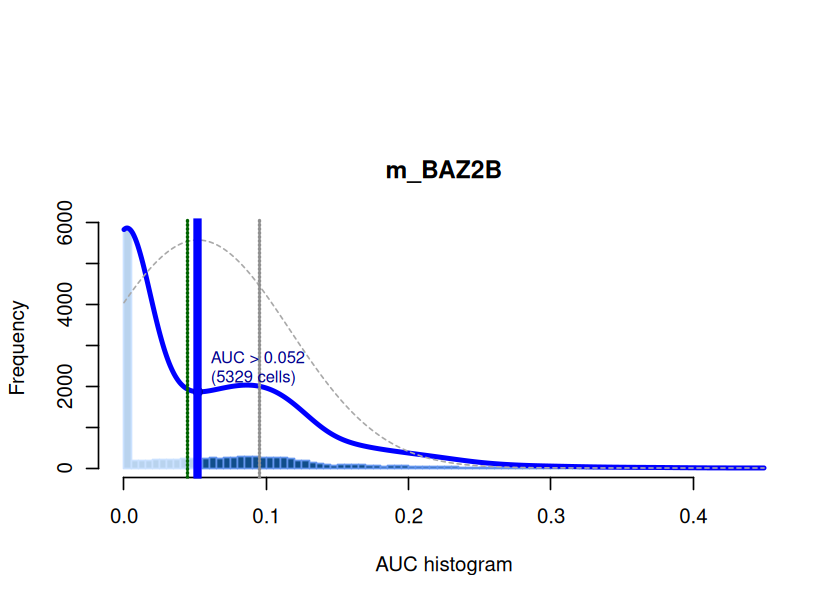

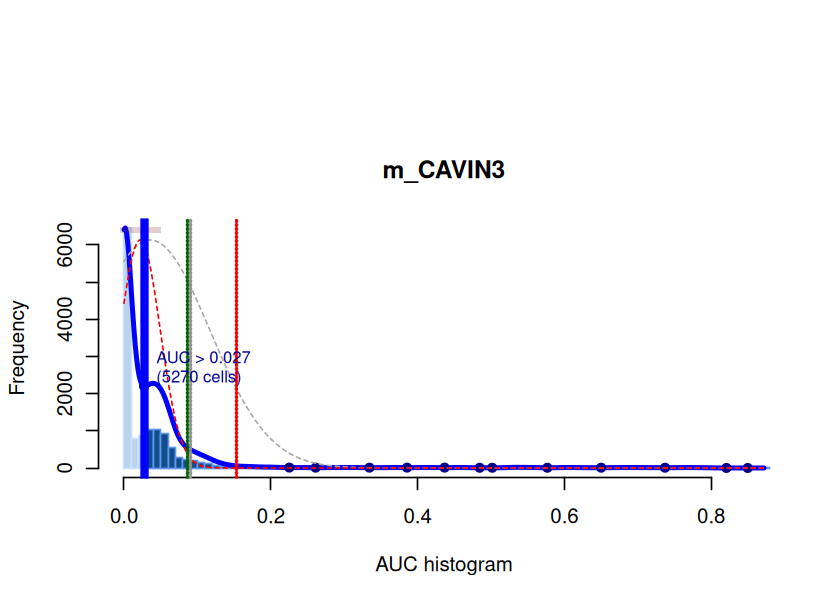

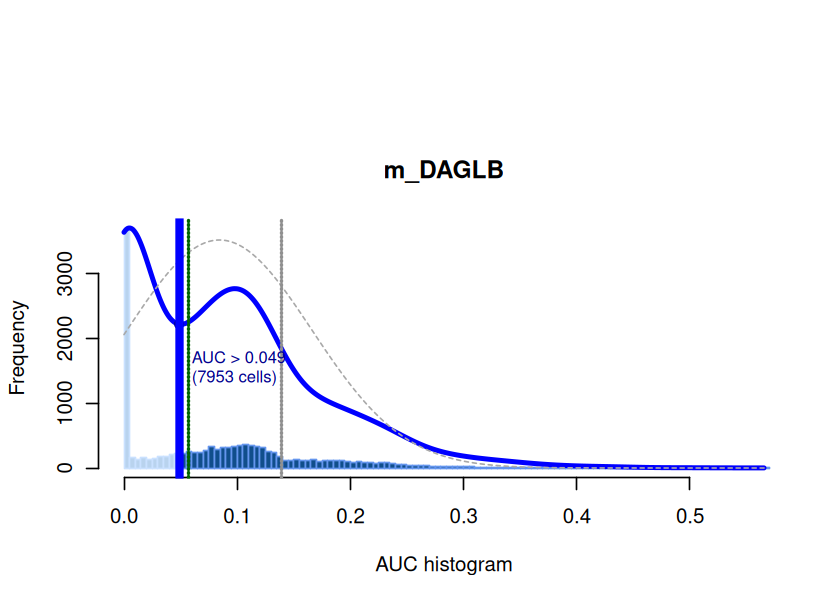

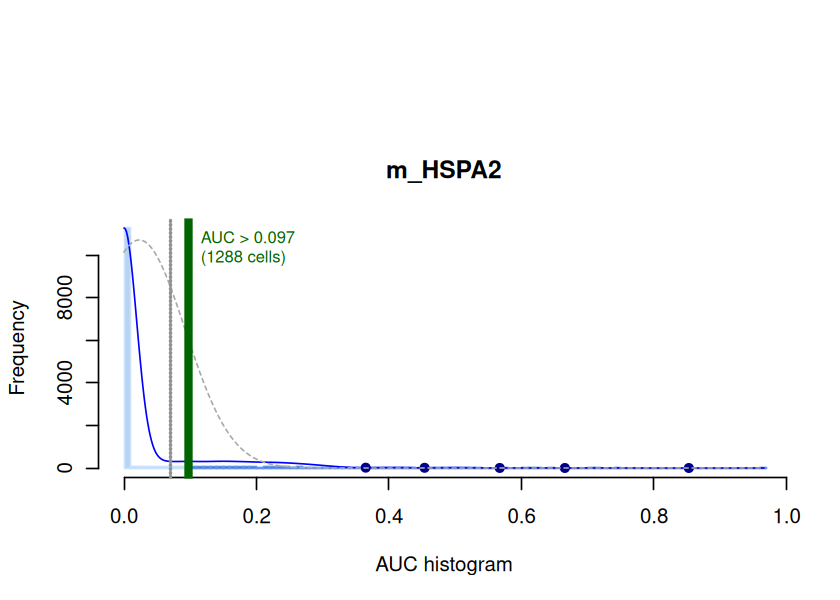

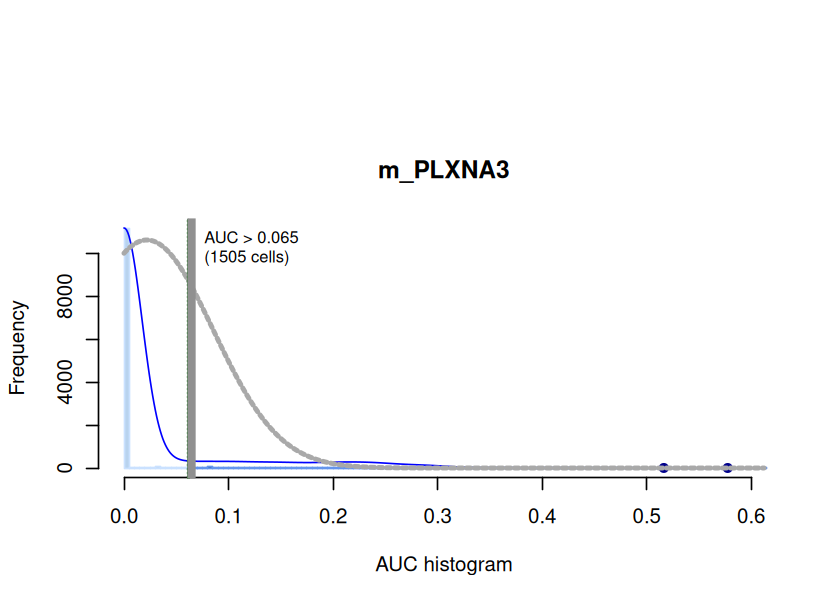

In [16]:
options(repr.plot.width =7, repr.plot.height=5)
exprMatrix <- Healthy_stomach_obj@assays$RNA@counts
cells_rankings <- AUCell_buildRankings(exprMatrix)
cells_AUC <- AUCell_calcAUC(Healthy_stomach_modules, cells_rankings, aucMaxRank=nrow(cells_rankings)*0.05) ## calculate AUC values 
cells_assignment <- AUCell_exploreThresholds(cells_AUC, plotHist=TRUE, nCores=1,assign=TRUE)## selecte thresholds 

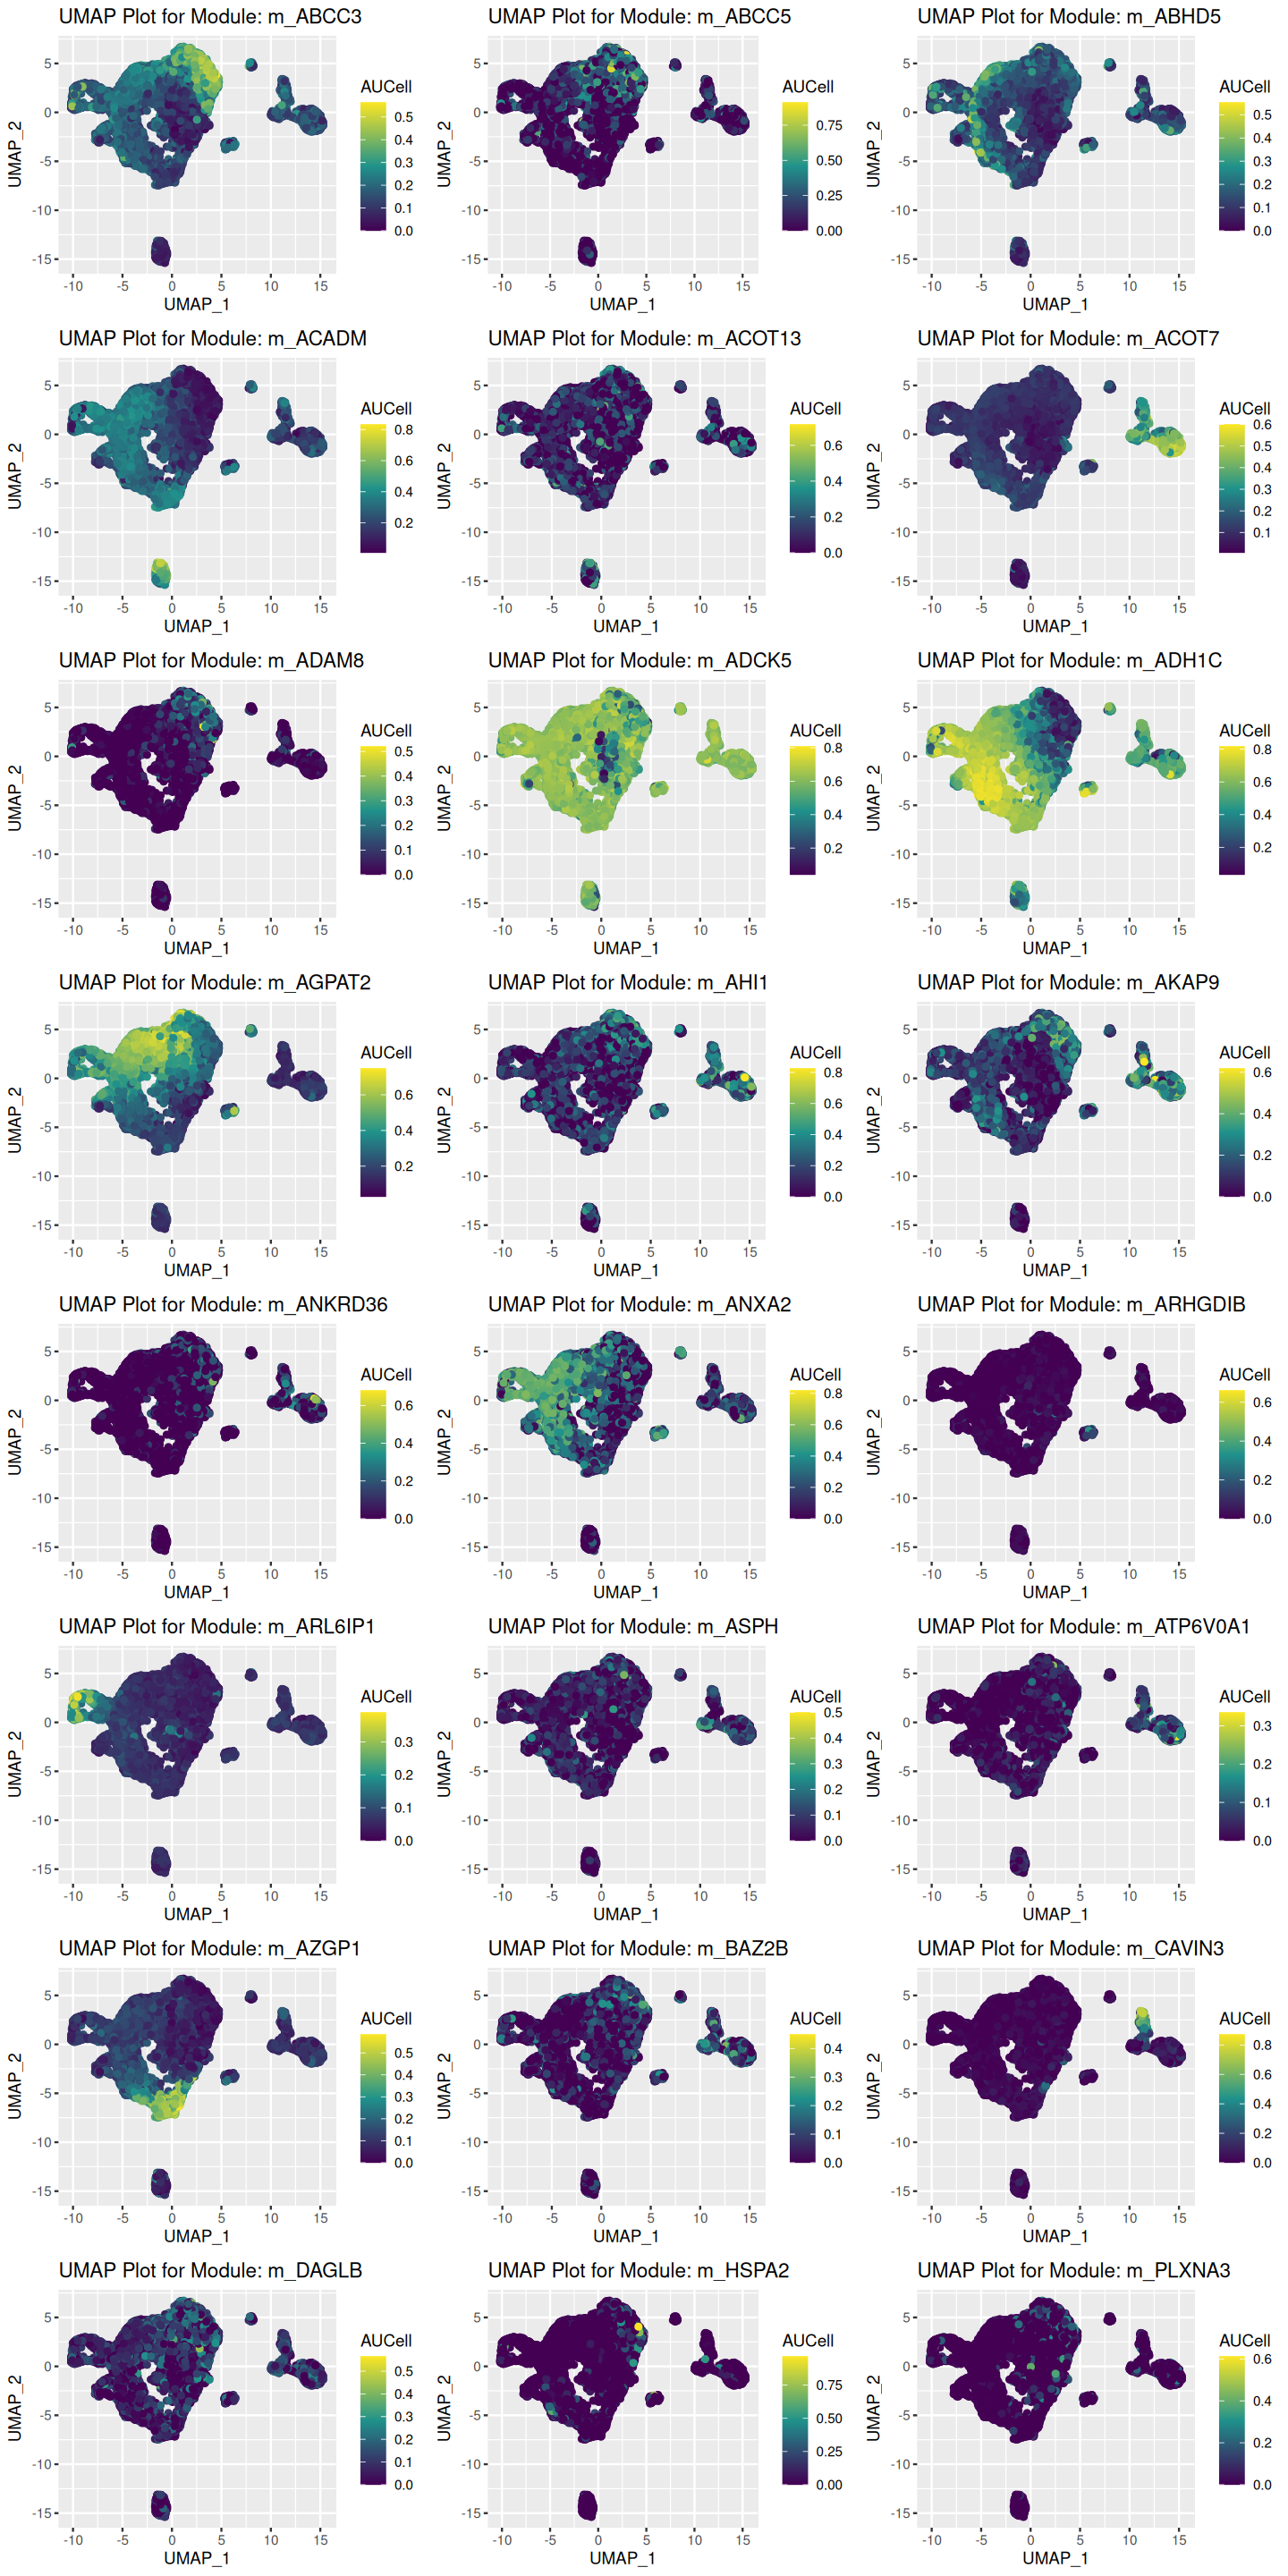

In [33]:
options(repr.plot.width =12, repr.plot.height=24)

custom_palette <- colorRampPalette(c("#440154FF", "#20938CFF", "#FDE725FF"))
data <- Healthy_stomach_obj
plots <- lapply(names(Healthy_stomach_modules), plot_umap_for_module) 
plot_grid(plotlist = plots,ncol = 3)

In [71]:
AllTissue_merge <-readRDS('./03_AllTissue_merge.rds')

In [37]:
BE_modules <-readRDS('../04_Test_NMF_Program_0120/01_BE_modules.rds')

Healthy_intestine_modules <-readRDS('../04_Test_NMF_Program_0120/01_Healthy_intestine_modules.rds')

Healthy_stomach_modules <-readRDS('../04_Test_NMF_Program_0120/01_Healthy_stomach_modules.rds')

In [43]:
modules_list <- c(BE_modules,
                    Healthy_intestine_modules,
                   Healthy_stomach_modules)

In [51]:
new_names <- c(paste0("BE_modules", seq_along(BE_modules)),
               paste0("Healthy_intestine_modules", seq_along(Healthy_intestine_modules)), 
               paste0("Healthy_stomach_modules", seq_along(Healthy_stomach_modules)))  

modules_list <- setNames(modules_list, new_names) 

only keep modules which length of genes more than 3

In [119]:
filtered_modules_list <- Filter(function(x) length(x) > 3, modules_list)

In [ ]:
cells_rankings <- AUCell_buildRankings(AllTissue_merge@assays$RNA@data,splitByBlocks=TRUE) 

cells_AUC <- AUCell_calcAUC(filtered_modules_list, cells_rankings, 
                            aucMaxRank=nrow(cells_rankings)*0.1)


moduleScore <- getAUC(cells_AUC)

In [168]:
Erichment and Finsher

ERROR: Error in parse(text = input): <text>:1:11: unexpected symbol
1: Erichment and
              ^


In [122]:
AllTissue_merge[["module_AUC"]] <- CreateAssayObject(moduleScore)

DefaultAssay(AllTissue_merge) <- 'module_AUC'
# AllTissue_merge$Tissue_in_paper %>% unique

scoreE <- rowMeans(AllTissue_merge)

mergeData.list <- SplitObject(object = AllTissue_merge,split.by ='Tissue_in_paper' ) 

scoreO <- sapply(mergeData.list , rowMeans)

enrichScore <- log2(scoreO/scoreE)

#The enrichment of each group  to the overall mean

In [125]:
enrichScore[which(enrichScore <= -1 )] = -1

enrichScore[which(enrichScore > 1)] = 1

In [128]:
gene_fisher <- function(data=AllTissue_merge,Subcluster='Tissue_in_paper',assay = 'RNA',slot = 'counts',gene=node$name,cellTpye="Fibroblast",cutoff=1){
            fisher_list <- list()
            fibcell <- colnames(data)[which(data@meta.data[,Subcluster] %in% cellTpye)]
            #gene <- intersect(gene,rownames(data))
            fisher <- data.frame(gene=gene,OR=0,P=0,P.adjust=0,number_of_cell_expGene=0,Proportion=0)
            rownames(fisher) <- gene
            exp <- GetAssayData(data,assay = assay,slot = slot)
            for(i in gene){
                if(i %in% rownames(data)){
                    cell_expGene <- names(exp[i,][which(exp[i,]>cutoff)]) 
               fisher_matrix <- matrix(c(length(intersect(fibcell,cell_expGene)),
                              length(cell_expGene)-length(intersect(fibcell,cell_expGene)),
                              length(fibcell)-length(intersect(fibcell,cell_expGene)),
                              ncol(data)-length(cell_expGene)-length(fibcell)+length(intersect(fibcell,cell_expGene))),
                              nrow=2)
                res <- fisher.test(fisher_matrix,alternative='greater')
                fisher[i,'OR'] <- as.vector(res[[3]])
                fisher[i,'P'] <- as.vector(res[[1]])
                fisher[i,'P.adjust'] <- p.adjust(as.vector(res[[1]]),n = length(gene))
                fisher[i,'number_of_cell_expGene'] <- fisher_matrix[1]
                fisher[i,'Proportion'] <- fisher_matrix[1]/(fisher_matrix[1]+fisher_matrix[2])   
                }else{
                fisher[i,'OR'] <- NA
                fisher[i,'P'] <- NA
                fisher[i,'P.adjust'] <- NA
                fisher[i,'number_of_cell_expGene'] <- NA
                fisher[i,'Proportion'] <- NA       
                }
            }

    return(fisher)
}

In [129]:
enrichScore_P <- matrix(data = 1,nrow = nrow(scoreO),ncol = ncol(scoreO))
colnames(enrichScore_P) <- colnames(scoreO)
rownames(enrichScore_P) <- rownames(scoreO)
for(i in rownames(enrichScore_P)){
    for(j in colnames(enrichScore_P)){
        enrichScore_P[i,j] <- gene_fisher(data = AllTissue_merge,Subcluster = 'Tissue_in_paper',assay = 'module_AUC',slot = 'data',gene = i,cellTpye = j,cutoff =scoreE[i])$P[1]
    }
}


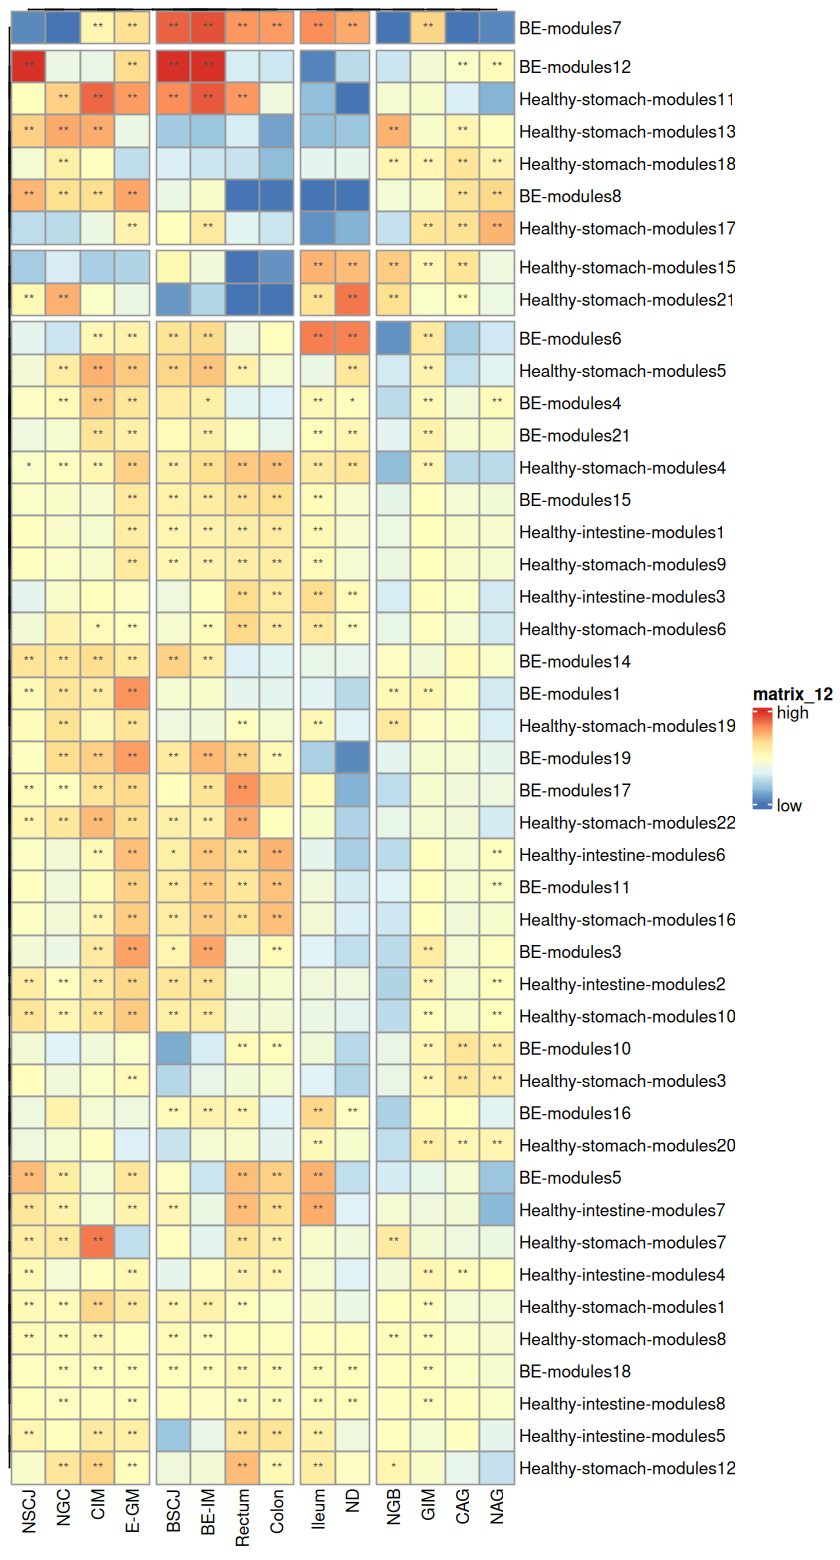

In [130]:
options(repr.plot.width =7, repr.plot.height=13)

p1 <- pheatmap(enrichScore,cluster_cols=T, cluster_rows = T,display_numbers = ifelse(enrichScore_P <= 0.001, "**", ifelse(enrichScore_P<=0.01,'*','')),legend_breaks = c(-1, 1),treeheight_row = 0,treeheight_col = 0, legend_labels = c("low", "high"),cutree_cols = 4,cutree_rows = 4)
p1

In [3]:
filtered_modules_list$BE_modules7

filtered_modules_list$Healthy_stomach_modules7

[1] "AGR3"    "CLDN4"   "CLDN7"   "GPA33"   "KRT17"   "LGALS4"  "ONECUT2"
 [8] "PRSS3"   "REG4"    "S100A10" "SQLE"    "TMEM45B"

In [167]:

dir_name <- 'Test_NMF_Program_0120_all_variable'
save.image(file = paste0('../04_Test_NMF_Program_0120', "/", 'Rdata_',dir_name, ".RData"))

In [2]:
load('/mnt/data00/minghui/project_NMF/04_Test_NMF_Program_0120/Rdata_Test_NMF_Program_0120_all_variable.RData')

In [4]:
filtered_modules_list

$BE_modules1
 [1] "A4GNT"    "AQP5"     "ASCL2"    "BPIFB1"   "C16orf89" "CD74"    
 [7] "CDCA7"    "CLDN10"   "CLDN2"    "CLU"      "CXCL17"   "DMKN"    
[13] "ELAPOR1"  "EPHB3"    "FAM3D"    "FMOD"     "FUT9"     "FXYD5"   
[19] "HLA.DMA"  "HLA.DPA1" "HLA.DRA"  "HLA.DRB1" "HLA.DRB5" "IFI6"    
[25] "IFITM3"   "KCNE2"    "LCN2"     "LIPF"     "LTF"      "LY6E"    
[31] "LYZ"      "MIA"      "MUC5B"    "MUC6"     "PDIA2"    "PDZK1IP1"
[37] "PGC"      "PIGR"     "PSMB9"    "RPS20"    "SELENOM"  "SLC12A2" 
[43] "SOD3"     "SYNE2"    "TESC"     "ZG16B"   

$BE_modules3
[1] "ACAT2"  "AGR2"   "FDPS"   "HMGCR"  "IDI1"   "INSIG1" "MVD"    "OCIAD2"
[9] "SCD"   

$BE_modules4
 [1] "ADGRF1" "EPS8L1" "GUCA2B" "HLA.E"  "ISG15"  "LAMB3"  "NTHL1"  "PCDH1" 
 [9] "SAMD9"  "SDCBP2" "SMIM6"  "SQSTM1" "TRIM29" "TXNIP" 

$BE_modules5
 [1] "ADH1C"    "C15orf48" "CAPS"     "CLDN15"   "GSTA1"    "MT1E"    
 [7] "MT1F"     "MT1G"     "MT1H"     "MT1M"     "MT1X"     "MT2A"    
[13] "NKX6.2"   "NUPR1"    "SCGB2A1"  "TAGLN2"   "UGT2B15" 

$BE_modules6
 [1] "ADIRF"    "AKR1C3"   "ALDOB"    "ANPEP"    "ANXA10"   "ANXA13"  
 [7] "C11orf86" "CEACAM5"  "CEACAM6"  "CES2"     "CLDN23"   "COL17A1" 
[13] "CRIP1"    "DEFB1"    "DHRS11"   "FABP1"    "FABP2"    "FXYD3"   
[19] "HPGD"     "IL32"     "ISG20"    "KRT19"    "KRT20"    "KRT8"    
[25] "LGALS3"   "LMO4"     "MALL"     "PHGR1"    "PLAC8"    "PRAP1"   
[31] "RGS2"     "SI"       "SLC26A3"  "SMIM24"   "SULT1A1"  "SULT1A2" 
[37] "TM4SF20"  "TM4SF4"   "TSPAN1"   "TSPAN8"  

$BE_modules7
 [1] "AGR3"    "CLDN4"   "CLDN7"   "GPA33"   "KRT17"   "LGALS4"  "ONECUT2"
 [8] "PRSS3"   "REG4"    "S100A10" "SQLE"    "TMEM45B"

$BE_modules8
 [1] "AKR1B10" "AKR1C1"  "AKR1C2"  "ALDH3A1" "ATP2A3"  "CA2"     "CYSTM1" 
 [8] "FGFBP1"  "GKN1"    "GKN2"    "HMGCS1"  "ID1"     "IFI27"   "IL1R2"  
[15] "MSMO1"   "MUC5AC"  "MUCL3"   "PKIB"    "PSCA"    "RAB27A"  "S100P"  
[22] "SFTA2"   "SLC5A5"  "SPINK1"  "SPTSSB"  "SULT1C2" "TFF1"    "VSIG1"  

$BE_modules10
 [1] "ANKRD37"   "AREG"      "ARL14"     "ARL5B"     "ATF3"      "BTG2"     
 [7] "C3orf52"   "CD55"      "CSRNP1"    "CXCL3"     "CXCL8"     "DNAJA1"   
[13] "DNAJB1"    "DUSP1"     "EFNA1"     "EGR1"      "ERRFI1"    "ETS2"     
[19] "EZR"       "FOS"       "FOSB"      "FRMD4B"    "GADD45B"   "GDF15"    
[25] "HBEGF"     "HERPUD1"   "HSPA1A"    "HSPA1B"    "IER2"      "IER3"     
[31] "IER5"      "ITPKC"     "JUN"       "JUNB"      "KDM6B"     "KLF2"     
[37] "KLF4"      "KLF6"      "MAFF"      "NCOA7"     "NFKBIA"    "NR4A1"    
[43] "ODC1"      "PHLDA2"    "PLAUR"     "PMAIP1"    "PPP1R15A"  "RAB11FIP1"
[49] "RHOB"      "RND3"      "SERTAD1"   "SGK1"      "SLC20A1"   "SLC38A2"  
[55] "SOCS3"     "TCIM"      "TENT5A"    "TGIF1"     "TMEM63B"   "TNFRSF12A"
[61] "TRIB1"     "TSC22D1"   "VMP1"      "YPEL2"     "ZBTB43"    "ZFP36"    
[67] "ZFP36L2"  

$BE_modules11
  [1] "ANLN"      "ANP32E"    "ARHGAP11A" "ARL6IP1"   "ASF1B"     "ASPM"     
  [7] "ATAD2"     "ATAD5"     "AURKA"     "AURKB"     "BIRC5"     "BRCA1"    
 [13] "BRCA2"     "BUB1"      "CCNA2"     "CCNB1"     "CCNB2"     "CDC20"    
 [19] "CDC25B"    "CDCA3"     "CDCA8"     "CDK1"      "CDKN3"     "CDT1"     
 [25] "CENPA"     "CENPE"     "CENPF"     "CENPK"     "CENPM"     "CENPN"    
 [31] "CENPU"     "CENPW"     "CENPX"     "CEP55"     "CHAF1A"    "CHEK1"    
 [37] "CKAP2"     "CKS1B"     "CKS2"      "DDX39A"    "DEK"       "DEPDC1"   
 [43] "DHFR"      "DLGAP5"    "DNAJC9"    "DNMT1"     "DTYMK"     "DUT"      
 [49] "ECT2"      "FAM111B"   "FANCI"     "FEN1"      "GGCT"      "GGH"      
 [55] "GINS2"     "GMNN"      "GPSM2"     "GTSE1"     "H2AX"      "H2AZ1"    
 [61] "H4C3"      "HELLS"     "HMGA1"     "HMGB1"     "HMGB2"     "HMGB3"    
 [67] "HMGN2"     "HMMR"      "HSP90AA1"  "HSPE1"     "KIF11"     "KIF20B"   
 [73] "KIF23"     "KIF4A"     "KIFC1"     "KNL1"      "KNSTRN"    "KPNA2"    
 [79] "LBR"       "LIG1"      "LMNB1"     "LSM5"      "MAD2L1"    "MCM2"     
 [85] "MCM3"      "MCM4"      "MCM5"   

In [29]:
celltype.list <- SplitObject(object = mergeData.list[[1]],split.by ='Detailed_Cell_Type' ) 

scoreO <- sapply(celltype.list , rowMeans) 

enrichScore <- log2(scoreO/scoreE)

enrichScore[which(enrichScore <= -1 )] = -1

enrichScore[which(enrichScore > 1)] = 1

enrichScore_P <- matrix(data = 1,nrow = nrow(scoreO),ncol = ncol(scoreO))
colnames(enrichScore_P) <- colnames(scoreO)
rownames(enrichScore_P) <- rownames(scoreO)
for(i in rownames(enrichScore_P)){
    for(j in colnames(enrichScore_P)){
        enrichScore_P[i,j] <- gene_fisher(data = AllTissue_merge,Subcluster = 'Detailed_Cell_Type',assay = 'module_AUC',slot = 'data',gene = i,cellTpye = j,cutoff =scoreE[i])$P[1]
    }
}


options(repr.plot.width =7, repr.plot.height=13)

p1 <- pheatmap(enrichScore,
               name = 'Enrich score' ,
               main = names(mergeData.list )[[1]],
               cluster_cols=T, 
               cluster_rows = T,
               display_numbers = ifelse(enrichScore_P <= 0.001, "**", ifelse(enrichScore_P<=0.01,'*','')),
               legend_breaks = c(-1, 1),treeheight_row = 0,
               treeheight_col = 0, legend_labels = c("low", "high"),
               cutree_cols = 4,cutree_rows = 4)
p1

In [46]:
# library(Seurat)
# library(pheatmap)

pdf(file = "./04_Test_NMF_Program_0120/enrichScore_heatmaps.pdf", width = 7, height = 13)

for (idx in seq_along(mergeData.list)) {

    celltype.list <- SplitObject(object = mergeData.list[[idx]], split.by = 'Detailed_Cell_Type')
  
  scoreO <- sapply(celltype.list, rowMeans)
  
  enrichScore <- log2(scoreO / scoreE)
  enrichScore[which(enrichScore <= -1)] <- -1
  enrichScore[which(enrichScore > 1)] <- 1
  
  enrichScore_P <- matrix(data = 1, nrow = nrow(scoreO), ncol = ncol(scoreO))
  colnames(enrichScore_P) <- colnames(scoreO)
  rownames(enrichScore_P) <- rownames(scoreO)
  
  for (i in rownames(enrichScore_P)) {
    for (j in colnames(enrichScore_P)) {
      enrichScore_P[i, j] <- gene_fisher(data = AllTissue_merge, Subcluster = 'Detailed_Cell_Type', assay = 'module_AUC', slot = 'data', gene = i, cellTpye  = j, cutoff = scoreE[i])$P[1]
    }
  }
  
  p<- pheatmap(
    enrichScore,
    name = 'Enrich score',
    main = names(mergeData.list)[[idx]],
    cluster_cols = TRUE,
    cluster_rows = TRUE,
    display_numbers = ifelse(enrichScore_P <= 0.001, "**", ifelse(enrichScore_P <= 0.01, '*', '')),
    legend_breaks = c(-1, 1),
    treeheight_row = 0,
    treeheight_col = 0,
    legend_labels = c("low", "high"),
    cutree_cols = 4,
    cutree_rows = 4
  )
   p
}

dev.off()


In [53]:
enrichScore_list <- list()
enrichScore_P_list <- list()

for (idx in seq_along(mergeData.list)) {
  celltype.list <- SplitObject(object = mergeData.list[[idx]], split.by = 'Detailed_Cell_Type')
  
  scoreO <- sapply(celltype.list, rowMeans)
  
  enrichScore <- log2(scoreO / scoreE)
  enrichScore[which(enrichScore <= -1)] <- -1
  enrichScore[which(enrichScore > 1)] <- 1
  
  enrichScore_P <- matrix(data = 1, nrow = nrow(scoreO), ncol = ncol(scoreO))
  colnames(enrichScore_P) <- colnames(scoreO)
  rownames(enrichScore_P) <- rownames(scoreO)
  
  for (i in rownames(enrichScore_P)) {
    for (j in colnames(enrichScore_P)) {
      enrichScore_P[i, j] <- gene_fisher(data = AllTissue_merge, Subcluster = 'Detailed_Cell_Type', assay = 'module_AUC', slot = 'data', gene = i, cellTpye  = j, cutoff = scoreE[i])$P[1]
    }
  }
  
  enrichScore_list[[names(mergeData.list)[[idx]]]] <- enrichScore
  enrichScore_P_list[[names(mergeData.list)[[idx]]]] <- enrichScore_P
}



In [66]:
setwd("/mnt/data00/minghui/project_NMF/04_Test_NMF_Program_0120/")

saveRDS(enrichScore_list, file = "03_enrichScore_list.rds")

saveRDS(enrichScore_P_list, file = "03_enrichScore_P_list.rds")

saveRDS(filtered_modules_list, file = "01_filtered_modules_list.rds")

saveRDS(AllTissue_merge, file = "01_AllTissue_merge.rds")

saveRDS(modules_list, file = "01_modules_list.rds")

saveRDS(celltype.list, file = "03_celltype_list.rds")

saveRDS(mergeData.list, file = "02_mergeData_list.rds")


In [135]:
heatmap_list <- list()

# pdf('./enrichScore_heatmaps.pdf',onefile =T)

for(i in 1: length(enrichScore_list)){
#     png(paste0(path,names(mergeData.list)[[i]] ,'_enrichScore_heatmaps.png' ),width = 5,height = 9,units = 'in',res = 600)

heatmap_list[[i]] <- pheatmap(
    enrichScore_list[[i]],
    name = 'Enrich score',
    main = names(mergeData.list)[[i]],
    cluster_cols = TRUE,
    cluster_rows = TRUE,
    display_numbers = ifelse(enrichScore_P_list[[i]] <= 0.001, "**", ifelse(enrichScore_P_list[[i]] <= 0.01, '*', '')),
    legend_breaks = c(-1, 1),
    treeheight_row = 0,
    treeheight_col = 0,
    legend_labels = c("low", "high"),
    cutree_cols = 4,
    cutree_rows = 4
  )

    
#     dev.off()
}


grob_list <- lapply(heatmap_list, function(h) grid.grabExpr(draw(h)))

In [156]:
save(heatmap_list,file = './04_heatmap_list.Rdata')

save(grob_list,file ='./04_grob_list.Rdata')

In [166]:
pdf("./04_heatmaps/00_combined_heatmaps.pdf", width = 15, height = 50)  
do.call(grid.arrange, c(grobs = grob_list, ncol = 3))  
dev.off()

png("./04_heatmaps/00_combined_heatmaps.png", res = 300,units = 'in',width = 15, height = 50)  
do.call(grid.arrange, c(grobs = grob_list, ncol = 3))  
dev.off()

pdf 
  2

pdf 
  2